# Football Analytics & Machine Learning

Proyecto de análisis de fútbol aplicando **clustering**, **clasificación** y **recomendación** de jugadores a partir de estadísticas de rendimiento (FBRef) e información de mercado (Transfermarkt).

> Nota: esta notebook es una versión “portfolio-ready” del trabajo original. Se prioriza claridad, reproducibilidad y resultados.


## Cómo ejecutar

1. Instalar dependencias (ver `requirements.txt` en el repositorio).
2. Abrir esta notebook y ejecutar las celdas en orden.
3. Asegurarse de contar con los archivos de datos en la carpeta indicada en la sección **Datos**.

## Datos

- **FBRef**: estadísticas de rendimiento por jugador/temporada.
- **Transfermarkt**: información de valor de mercado por jugador.

Los datasets se integran mediante identificadores/nombres normalizados (según disponibilidad), y se aplican filtros mínimos (por ejemplo, minutos jugados) para evitar observaciones poco representativas.


## Francisco Borda Rojas - Julio 2024

In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt


from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler 
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import NearestNeighbors

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

from sklearn.model_selection import train_test_split, KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from formulaic import Formula

import tensorflow as tf
import keras
from tf_regressor import train_test_split_scale_center

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

c:\Users\Fran\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


### Preprocesamiento

Cargamos el archivo "FBref2020-21.csv" en un DataFrame

In [2]:
futbol = pd.read_csv("FBRef2020-21.csv")
futbol.head()

Player  Nation Pos           Squad                Comp   Age  \
0  Patrick van Aanholt  nl NED  DF  Crystal Palace  eng Premier League  29.0   
1     Yunis Abdelhamid  ma MAR  DF           Reims          fr Ligue 1  32.0   
2      Pape Abou Cisse  sn SEN  DF   Saint-Étienne          fr Ligue 1  24.0   
3        David Abraham  ar ARG  DF  Eint Frankfurt       de Bundesliga  34.0   
4     Francesco Acerbi  it ITA  DF           Lazio          it Serie A  32.0   

     Born  MP  Starts   Min  ...  PrgDistCarry/90  ProgCarry/90  \
0  1990.0  22      20  1777  ...             96.8          5.79   
1  1987.0  33      33  2889  ...            130.5          1.81   
2  1995.0  14      14  1260  ...            117.9          1.14   
3  1986.0  14      14  1222  ...             92.7          3.24   
4  1988.0  32      32  2813  ...            166.3          3.71   

   CarryIntoThird/90  CarryIntoBox/90  Miscontrol/90  Dispossessed/90  \
0               1.52             0.46           0.66             0.81   
1               0.25             0.03           0.25             0.47   
2               0.07             0.00           0.14             0.07   
3               0.66             0.00           0.22             0.00   
4               1.02             0.03           0.45             0.26   

   PassTarget/90  PassesReceived/90  PassRec%  ProgPassReceived/90  
0           42.3               39.3      92.8                 2.34  
1           43.8               42.5      97.0                 0.22  
2           33.7               32.9      97.7                 0.00  
3           34.8               33.4      96.0                 0.59  
4           50.9               49.5      97.3                 0.70  

[5 rows x 128 columns]

Eliminamos los jugadores que jugaron menos de 500 minutos en la temporada

In [3]:
futbol = futbol[futbol['Min'] >= 500]

Ahora, eliminamos las columnas con más de 100 datos faltantes y eliminamos las filas con datos faltantes

In [4]:
# Eliminar columnas con más de 100 datos faltantes
futbol = futbol.loc[:, futbol.isnull().sum() <= 100]

# Eliminar ahora las filas con datos faltantes
futbol = futbol.dropna()

futbol.head()

Player  Nation Pos           Squad                Comp   Age  \
0  Patrick van Aanholt  nl NED  DF  Crystal Palace  eng Premier League  29.0   
1     Yunis Abdelhamid  ma MAR  DF           Reims          fr Ligue 1  32.0   
2      Pape Abou Cisse  sn SEN  DF   Saint-Étienne          fr Ligue 1  24.0   
3        David Abraham  ar ARG  DF  Eint Frankfurt       de Bundesliga  34.0   
4     Francesco Acerbi  it ITA  DF           Lazio          it Serie A  32.0   

     Born  MP  Starts   Min  ...  PrgDistCarry/90  ProgCarry/90  \
0  1990.0  22      20  1777  ...             96.8          5.79   
1  1987.0  33      33  2889  ...            130.5          1.81   
2  1995.0  14      14  1260  ...            117.9          1.14   
3  1986.0  14      14  1222  ...             92.7          3.24   
4  1988.0  32      32  2813  ...            166.3          3.71   

   CarryIntoThird/90  CarryIntoBox/90  Miscontrol/90  Dispossessed/90  \
0               1.52             0.46           0.66             0.81   
1               0.25             0.03           0.25             0.47   
2               0.07             0.00           0.14             0.07   
3               0.66             0.00           0.22             0.00   
4               1.02             0.03           0.45             0.26   

   PassTarget/90  PassesReceived/90  PassRec%  ProgPassReceived/90  
0           42.3               39.3      92.8                 2.34  
1           43.8               42.5      97.0                 0.22  
2           33.7               32.9      97.7                 0.00  
3           34.8               33.4      96.0                 0.59  
4           50.9               49.5      97.3                 0.70  

[5 rows x 122 columns]

Reseteamos los índices

In [5]:
futbol.reset_index(drop=True, inplace= True)
futbol.head()

Player  Nation Pos           Squad                Comp   Age  \
0  Patrick van Aanholt  nl NED  DF  Crystal Palace  eng Premier League  29.0   
1     Yunis Abdelhamid  ma MAR  DF           Reims          fr Ligue 1  32.0   
2      Pape Abou Cisse  sn SEN  DF   Saint-Étienne          fr Ligue 1  24.0   
3        David Abraham  ar ARG  DF  Eint Frankfurt       de Bundesliga  34.0   
4     Francesco Acerbi  it ITA  DF           Lazio          it Serie A  32.0   

     Born  MP  Starts   Min  ...  PrgDistCarry/90  ProgCarry/90  \
0  1990.0  22      20  1777  ...             96.8          5.79   
1  1987.0  33      33  2889  ...            130.5          1.81   
2  1995.0  14      14  1260  ...            117.9          1.14   
3  1986.0  14      14  1222  ...             92.7          3.24   
4  1988.0  32      32  2813  ...            166.3          3.71   

   CarryIntoThird/90  CarryIntoBox/90  Miscontrol/90  Dispossessed/90  \
0               1.52             0.46           0.66             0.81   
1               0.25             0.03           0.25             0.47   
2               0.07             0.00           0.14             0.07   
3               0.66             0.00           0.22             0.00   
4               1.02             0.03           0.45             0.26   

   PassTarget/90  PassesReceived/90  PassRec%  ProgPassReceived/90  
0           42.3               39.3      92.8                 2.34  
1           43.8               42.5      97.0                 0.22  
2           33.7               32.9      97.7                 0.00  
3           34.8               33.4      96.0                 0.59  
4           50.9               49.5      97.3                 0.70  

[5 rows x 122 columns]

Definimos el DataFrame data_num que solo contenga las variables númericas, a partir de la columna Ast/90, inclusive. A pedido del docente, para clustering y clasificación no vamos a utilizar las variables categóricas ni edad ni minutos jugados.


In [6]:
# Armamos DataFrame data_num

# Seleccionamos el indice de la columna Ast/90
indice_Ast90 = futbol.columns.get_loc('Ast/90')

# Seleccionamos todas las columnas a partir de Ast/90 y luego nos quedamos solo con las que tienen datos numéricos
data_num = futbol.iloc[:, indice_Ast90:].select_dtypes(include=[float, int])
data_num

Ast/90  npG/90  npG+A/90  xA/90  npxG/90  npxG+xA/90  Shots/90  SoTs/90  \
0       0.05    0.00      0.05   0.04     0.06        0.10      0.91     0.30   
1       0.00    0.09      0.09   0.01     0.05        0.06      0.47     0.16   
2       0.00    0.00      0.00   0.00     0.08        0.09      0.93     0.21   
3       0.00    0.07      0.07   0.03     0.05        0.08      0.66     0.15   
4       0.03    0.00      0.03   0.03     0.03        0.06      0.26     0.00   
...      ...     ...       ...    ...      ...         ...       ...      ...   
1897    0.00    0.14      0.14   0.00     0.09        0.09      1.11     0.14   
1898    0.19    0.19      0.39   0.11     0.22        0.33      2.13     0.84   
1899    0.17    0.14      0.31   0.18     0.11        0.28      1.03     0.41   
1900    0.21    0.21      0.42   0.14     0.12        0.26      1.47     0.63   
1901    0.08    0.08      0.15   0.09     0.14        0.22      1.14     0.53   

      FKSht/90  np:G-xG  ...  PrgDistCarry/90  ProgCarry/90  \
0         0.15    -0.06  ...             96.8          5.79   
1         0.00     0.04  ...            130.5          1.81   
2         0.00    -0.09  ...            117.9          1.14   
3         0.00     0.02  ...             92.7          3.24   
4         0.00    -0.03  ...            166.3          3.71   
...        ...      ...  ...              ...           ...   
1897      0.00     0.06  ...             76.3          3.47   
1898      0.00    -0.03  ...            138.4          8.71   
1899      0.03     0.03  ...            141.8          7.45   
1900      0.07     0.09  ...            102.0          5.24   
1901      0.00    -0.06  ...            117.3          5.30   

      CarryIntoThird/90  CarryIntoBox/90  Miscontrol/90  Dispossessed/90  \
0                  1.52             0.46           0.66             0.81   
1                  0.25             0.03           0.25             0.47   
2                  0.07             0.00           0.14             0.07   
3                  0.66             0.00           0.22             0.00   
4                  1.02             0.03           0.45             0.26   
...                 ...              ...            ...              ...   
1897               1.39             0.42           0.97             0.97   
1898               2.00             1.03           2.19             2.58   
1899               2.52             1.10           2.31             2.86   
1900               1.40             1.12           2.94             2.45   
1901               1.67             0.30           1.59             2.12   

      PassTarget/90  PassesReceived/90  PassRec%  ProgPassReceived/90  
0              42.3               39.3      92.8                 2.34  
1              43.8               42.5      97.0                 0.22  
2              33.7               32.9      97.7                 0.00  
3              34.8               33.4      96.0                 0.59  
4              50.9               49.5      97.3                 0.70  
...             ...                ...       ...                  ...  
1897           31.1               21.0      67.4                 2.78  
1898           58.1               44.3      76.2                 8.26  
1899           49.2               35.5      72.1                 8.21  
1900           40.3               28.0      69.3                 6.15  
1901           50.5               41.5      82.2                 4.02  

[1902 rows x 106 columns]

### Clustering

##

### Objetivo
Seleccionar dos variables cualesquiera de los datos y realizar un gráfico de dispersión de una variable en función de la otra para el total de las observaciones

### Enfoque
Se implementa el procedimiento descrito, documentando las decisiones de preprocesamiento y validando los resultados con visualizaciones y métricas cuando corresponde.


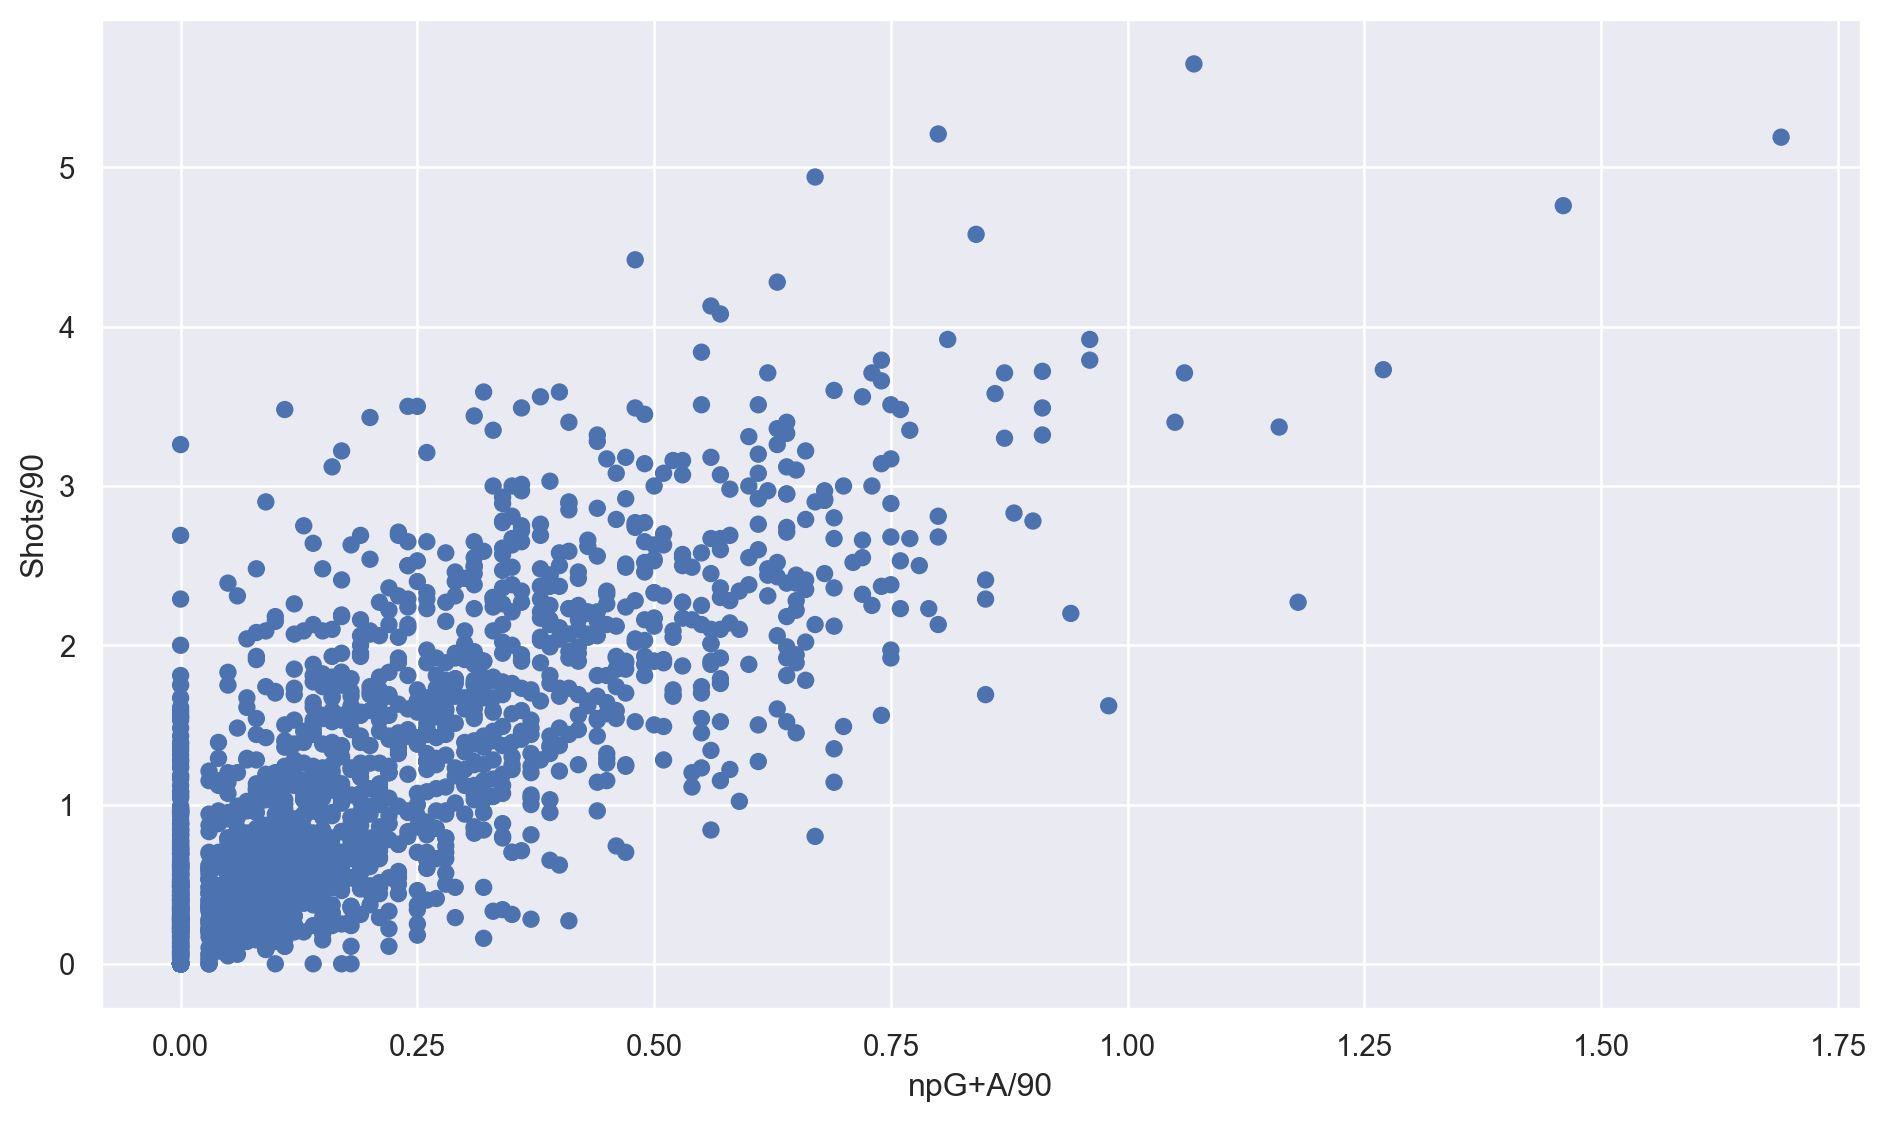

In [7]:
(
    so.Plot(data=data_num, x="npG+A/90", y="Shots/90")
    .add(so.Dot())
    .layout(size=(10,6))
)

En este grafico observamos sobre el eje X los goles + asistencias de los diferentes jugadores, y en el eje Y, los tiros al arco de los diferentes jugadores. Estas dos estadisticas están basadas en un promedio de cada 90 minutos. No encontramos facilmente grupos distintos.

### Objetivo
Escalar los datos y realizar un análisis de componentes principales, quedándose solo con las dos primeras componentes. Realizar un gráfico como el del punto ant

### Enfoque
Se implementa el procedimiento descrito, documentando las decisiones de preprocesamiento y validando los resultados con visualizaciones y métricas cuando corresponde.


In [8]:
# Escalamos los datos
data = StandardScaler().fit_transform(data_num)

# Aplicamos PCA
pca = PCA(n_components=2)

componentes = pca.fit_transform(data)
pca_data_num = pd.DataFrame(data=componentes, columns=["PC1", "PC2"])

pca_data_num.head()

PC1       PC2
0 -2.914489  2.251300
1 -6.818411 -1.413789
2 -6.474281 -3.792534
3 -5.082957 -1.910314
4 -7.441709  1.540059

Ya realizado el análisis de componentes principales vamos a realizar el grafico.

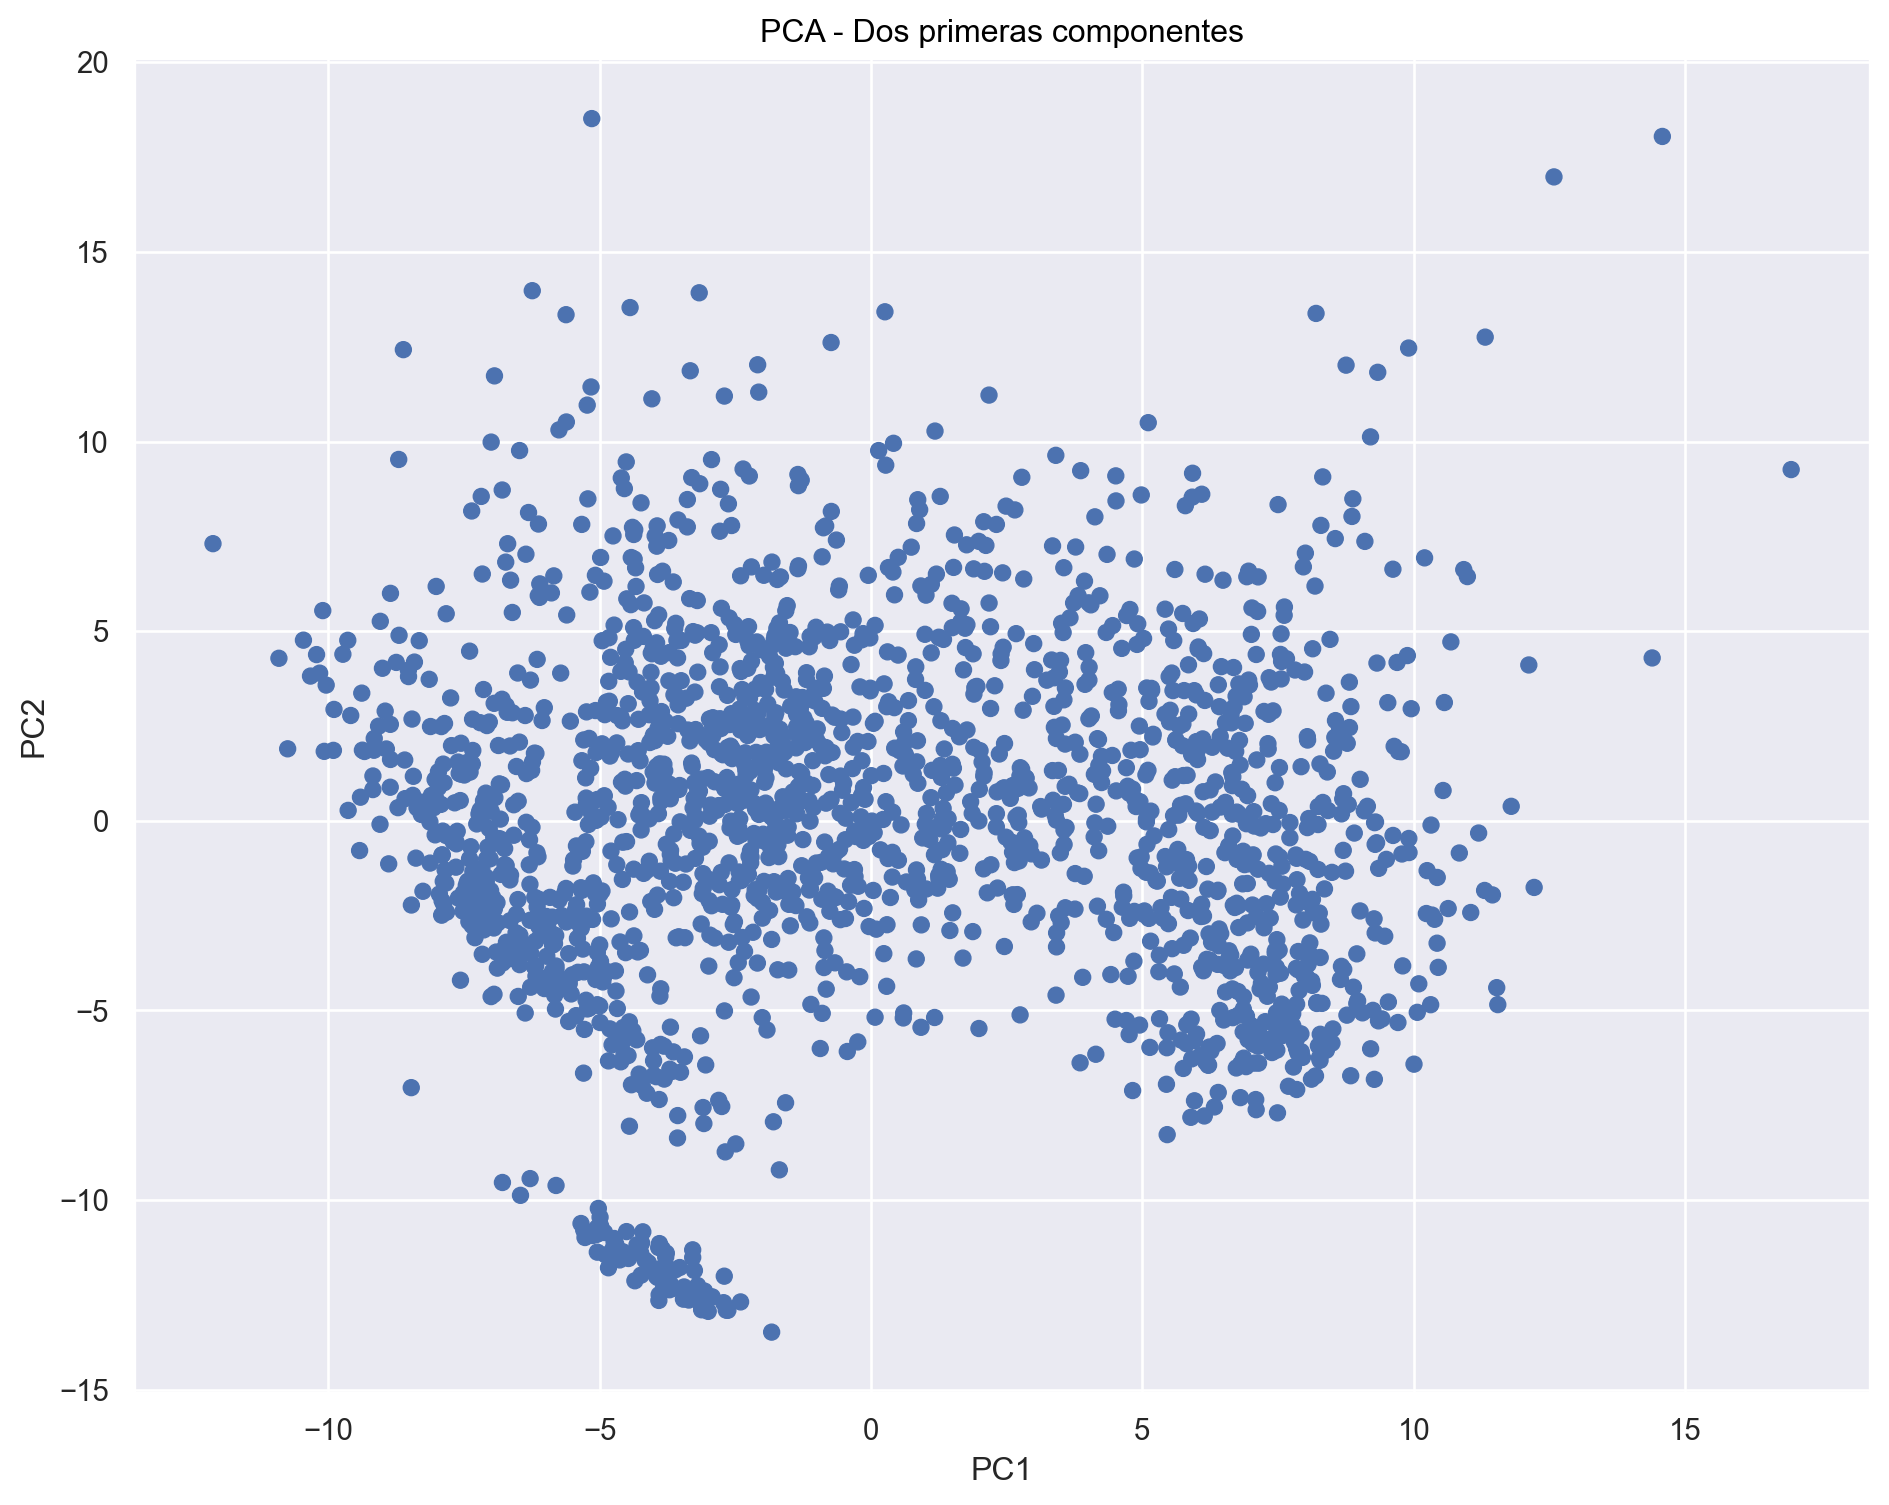

In [9]:
(
    so.Plot(data=pca_data_num, x="PC1", y="PC2")
    .add(so.Dot())
    .label(title="PCA - Dos primeras componentes")
    .layout(size=(10,8))
)

Observamos que podemos identificar principalmente dos clusters, uno muy grande que ocupa casi todo el grafico y uno muy chico que aparece en la parte baja del grafico. Si miramos más en detalle, podemos dividir el cluster grande en 2/3 clusters. Es decir, al final podemos visualizar hasta 4 clusters. A continuación vamos a crear estos clusters manualmente.

In [10]:
# Formo manualmente los clusters

clusters = [
    pca_data_num["PC2"] < -8,
    (pca_data_num["PC2"] >= -8) & (pca_data_num["PC1"] < -3),
    (pca_data_num["PC1"] >= -3) & (pca_data_num["PC1"] <= 3),
    pca_data_num["PC1"] > 3
]

opc = [0, 1, 2, 3]

# Asignar clusters basados en las condiciones
pca_data_num["Cluster"] = np.select(clusters, opc, default=-1)

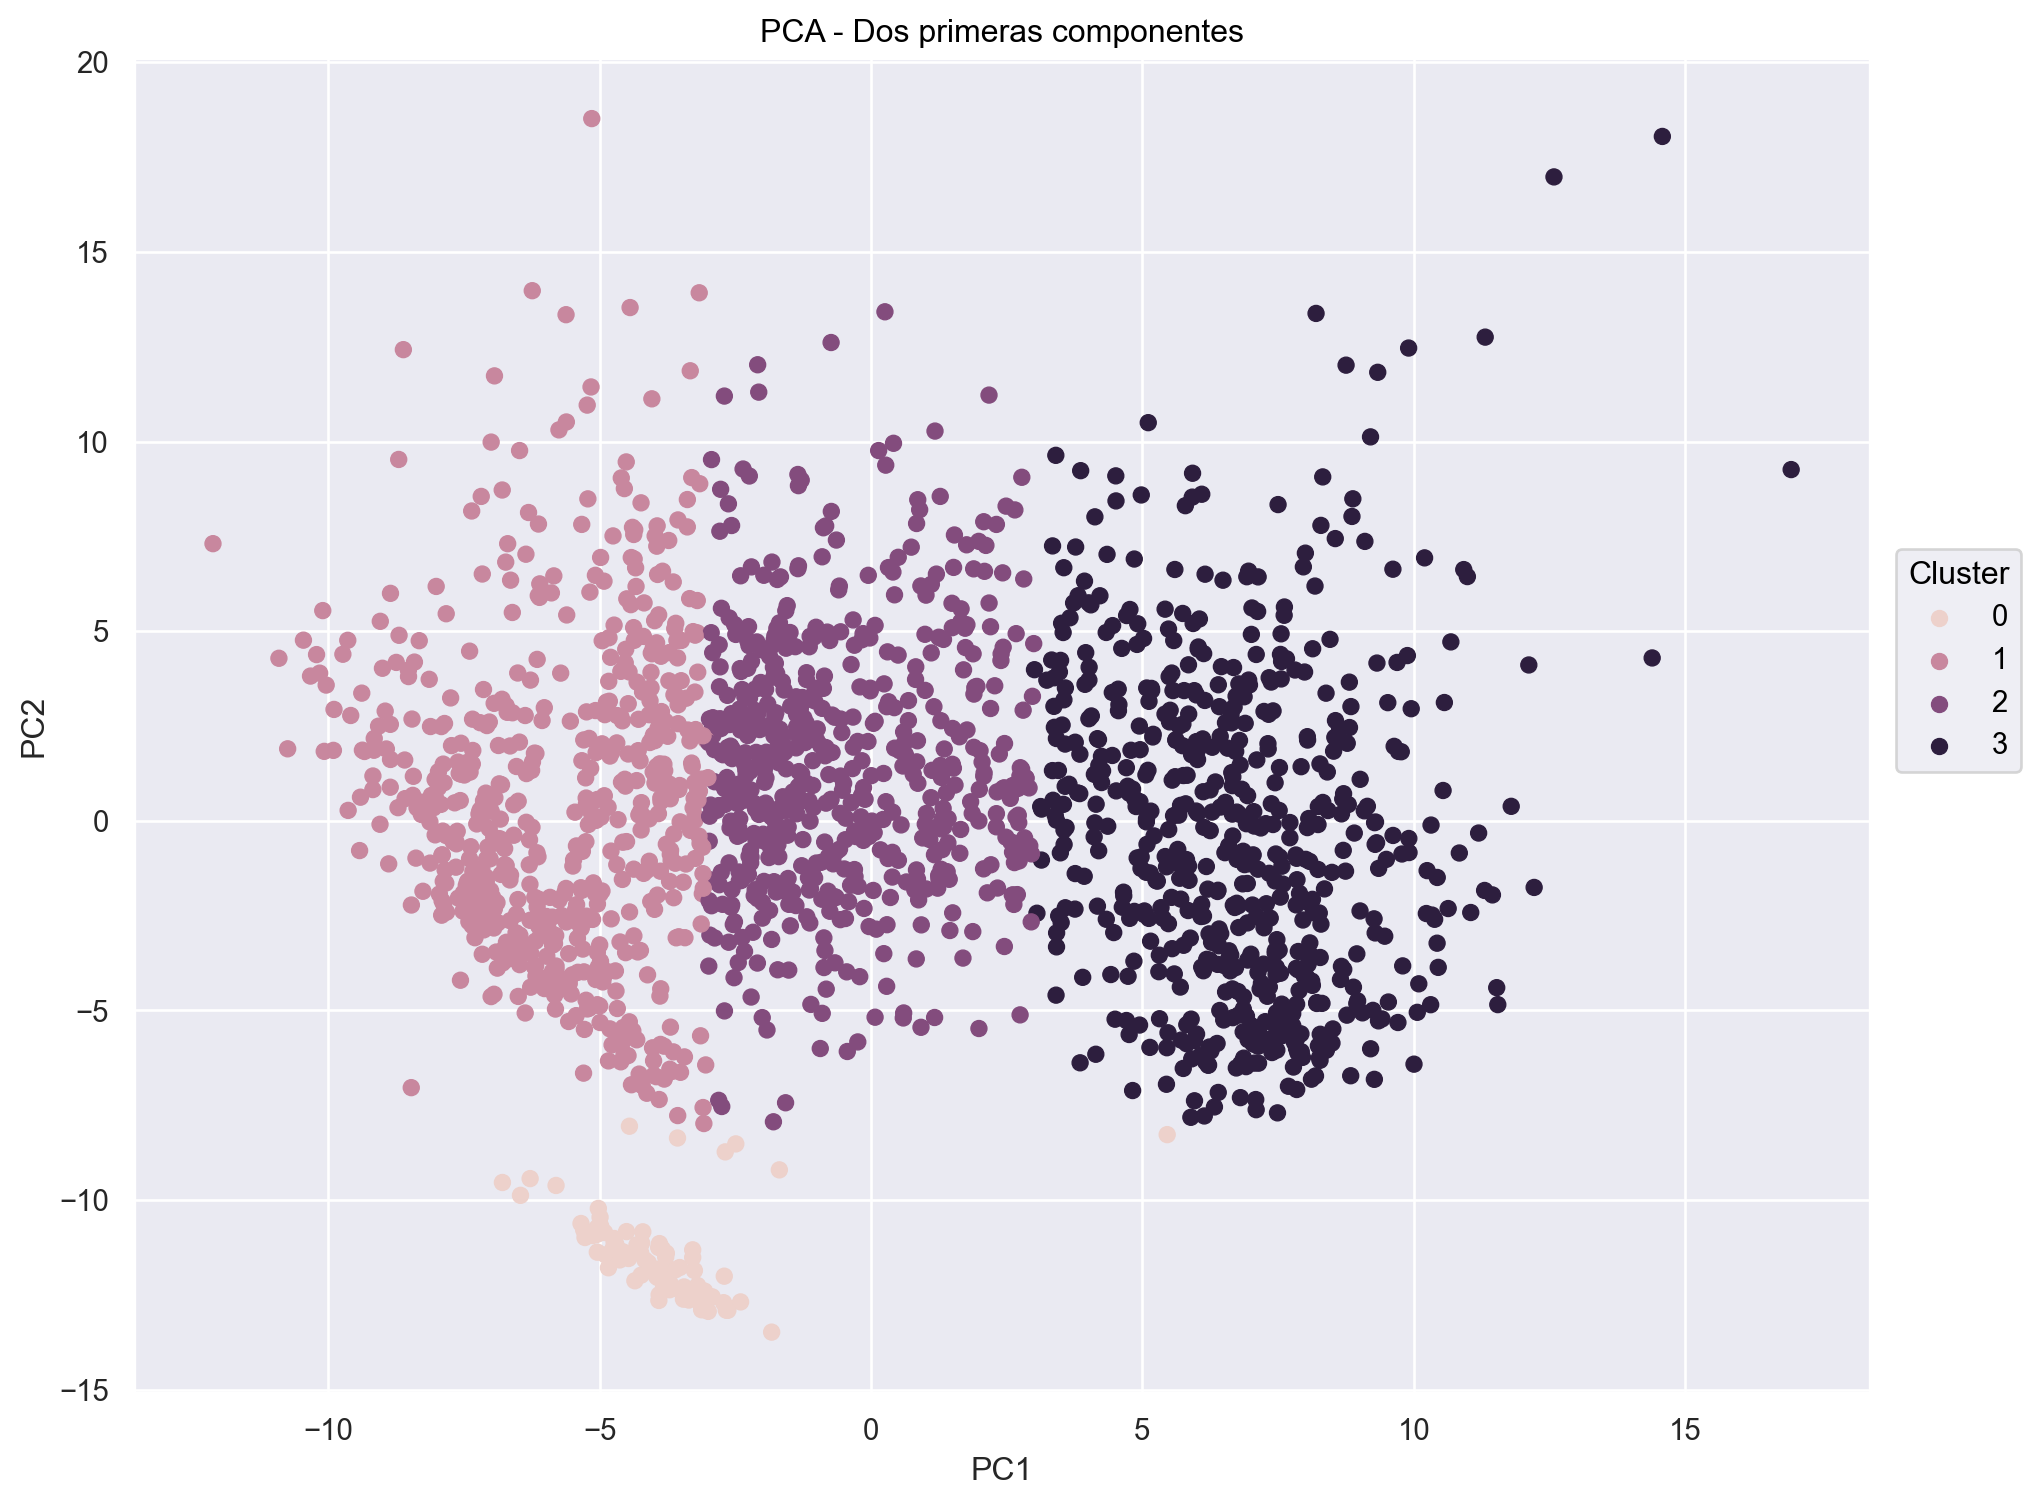

In [11]:
(
    so.Plot(data=pca_data_num, x="PC1", y="PC2", color = "Cluster")
    .add(so.Dot())
    .label(title="PCA - Dos primeras componentes")
    .layout(size=(10,8))
)

Vemos más claramente los clusters que mencionamos anteriormente. Ahora vamos a ver si podemos darnos cuenta a que características responden cada cluster.

In [12]:
data_num['Cluster'] = pca_data_num['Cluster']
cluster_analisis = data_num.groupby('Cluster').mean()

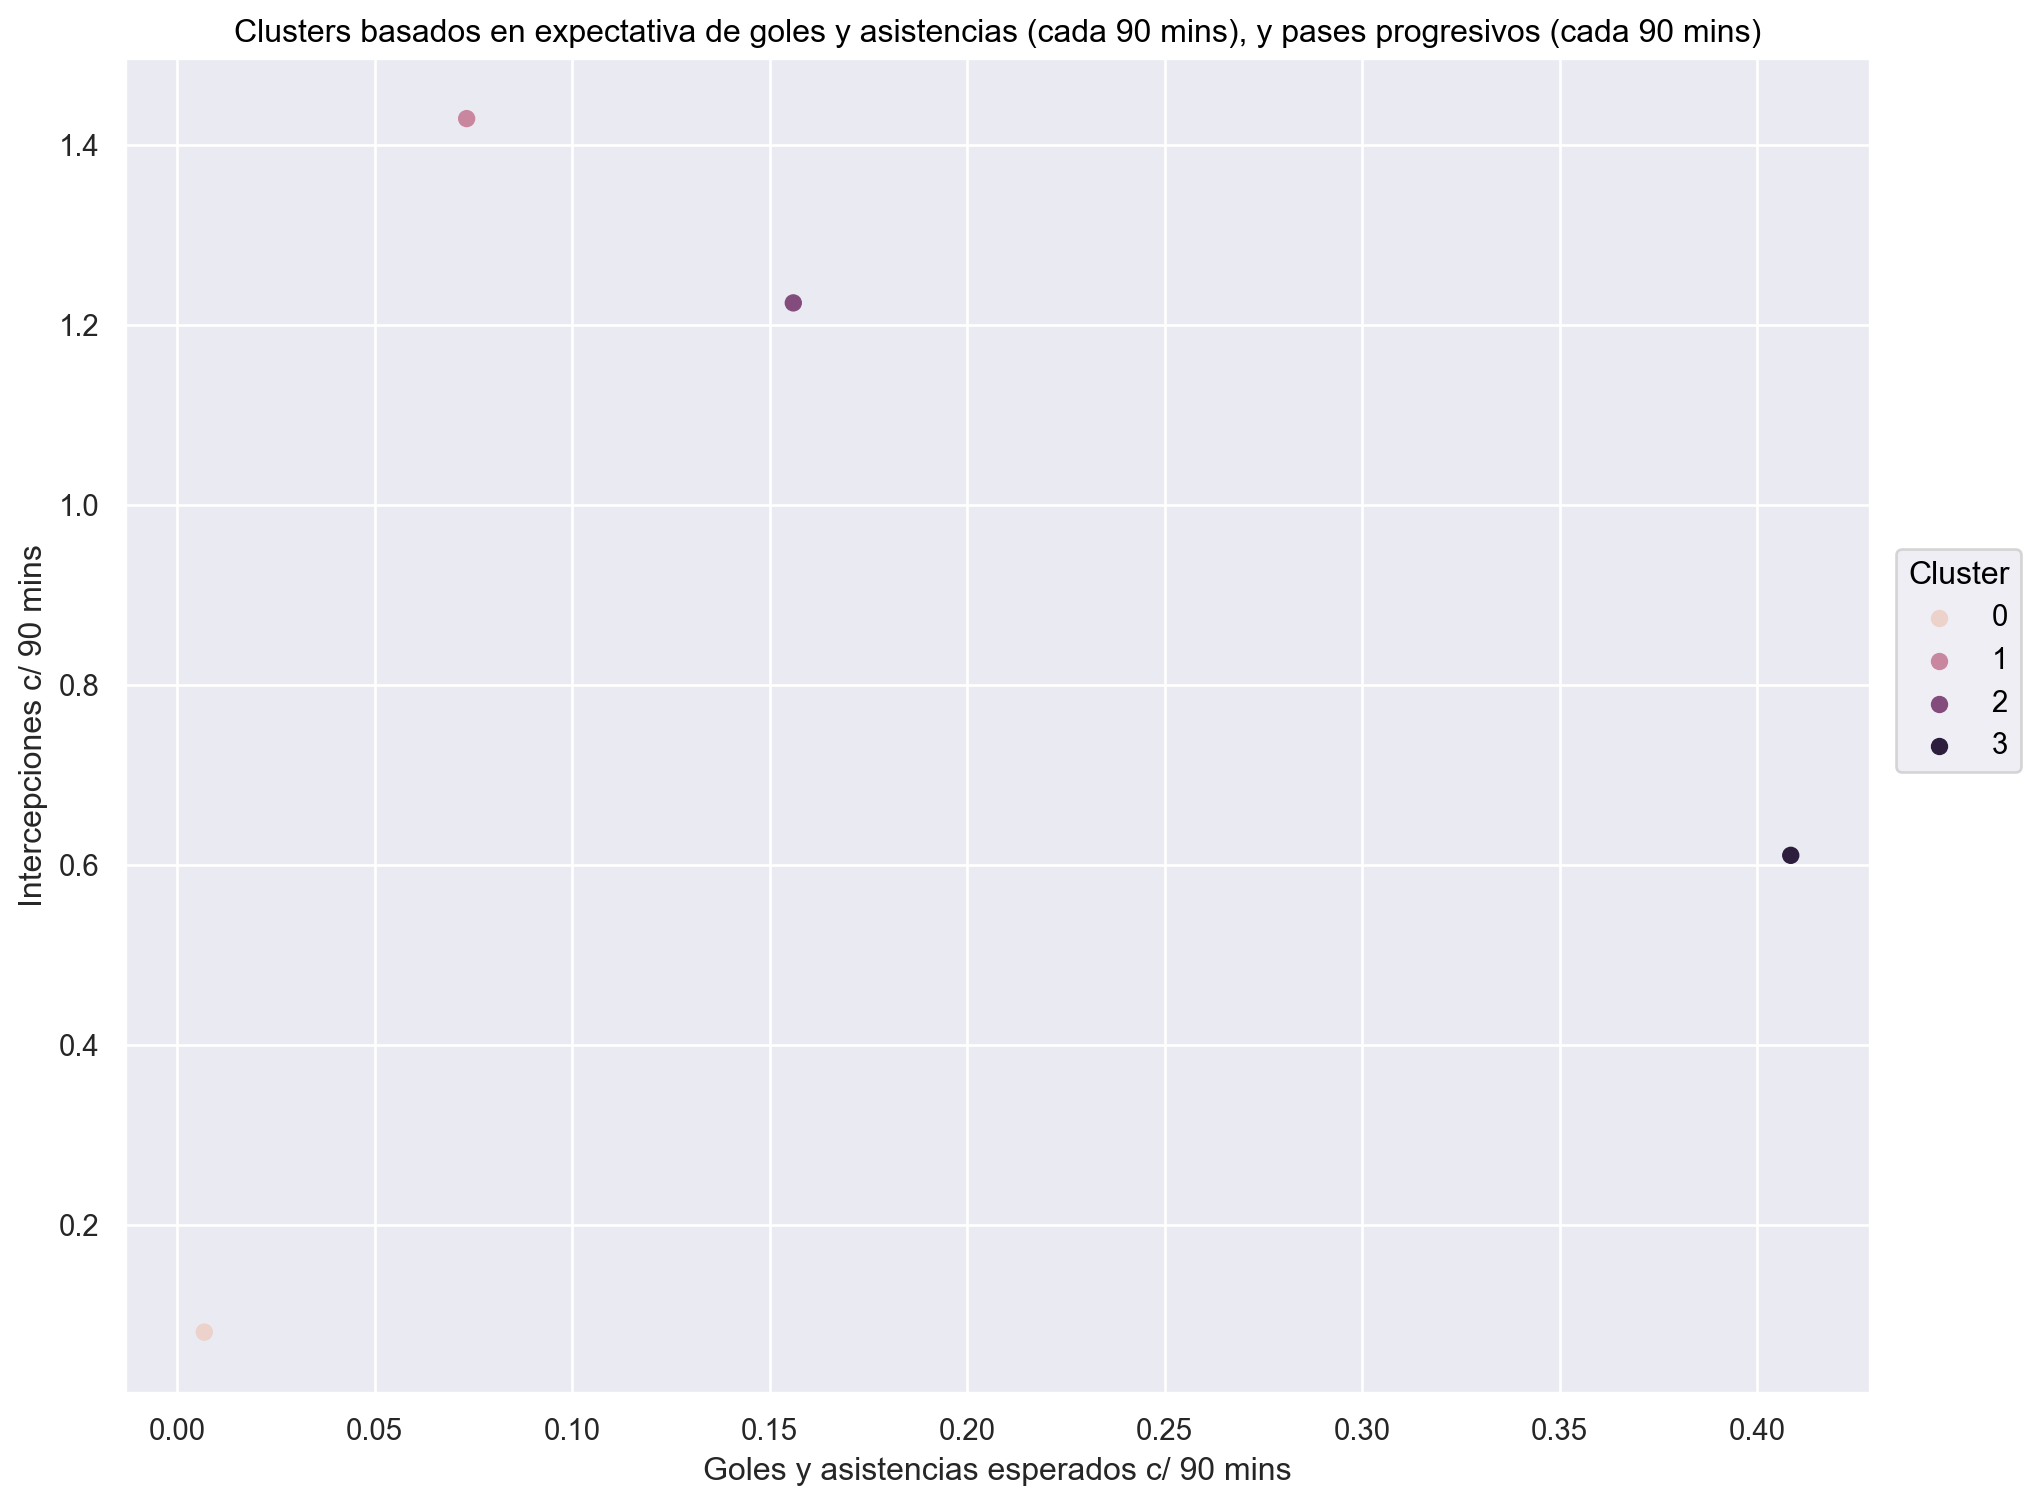

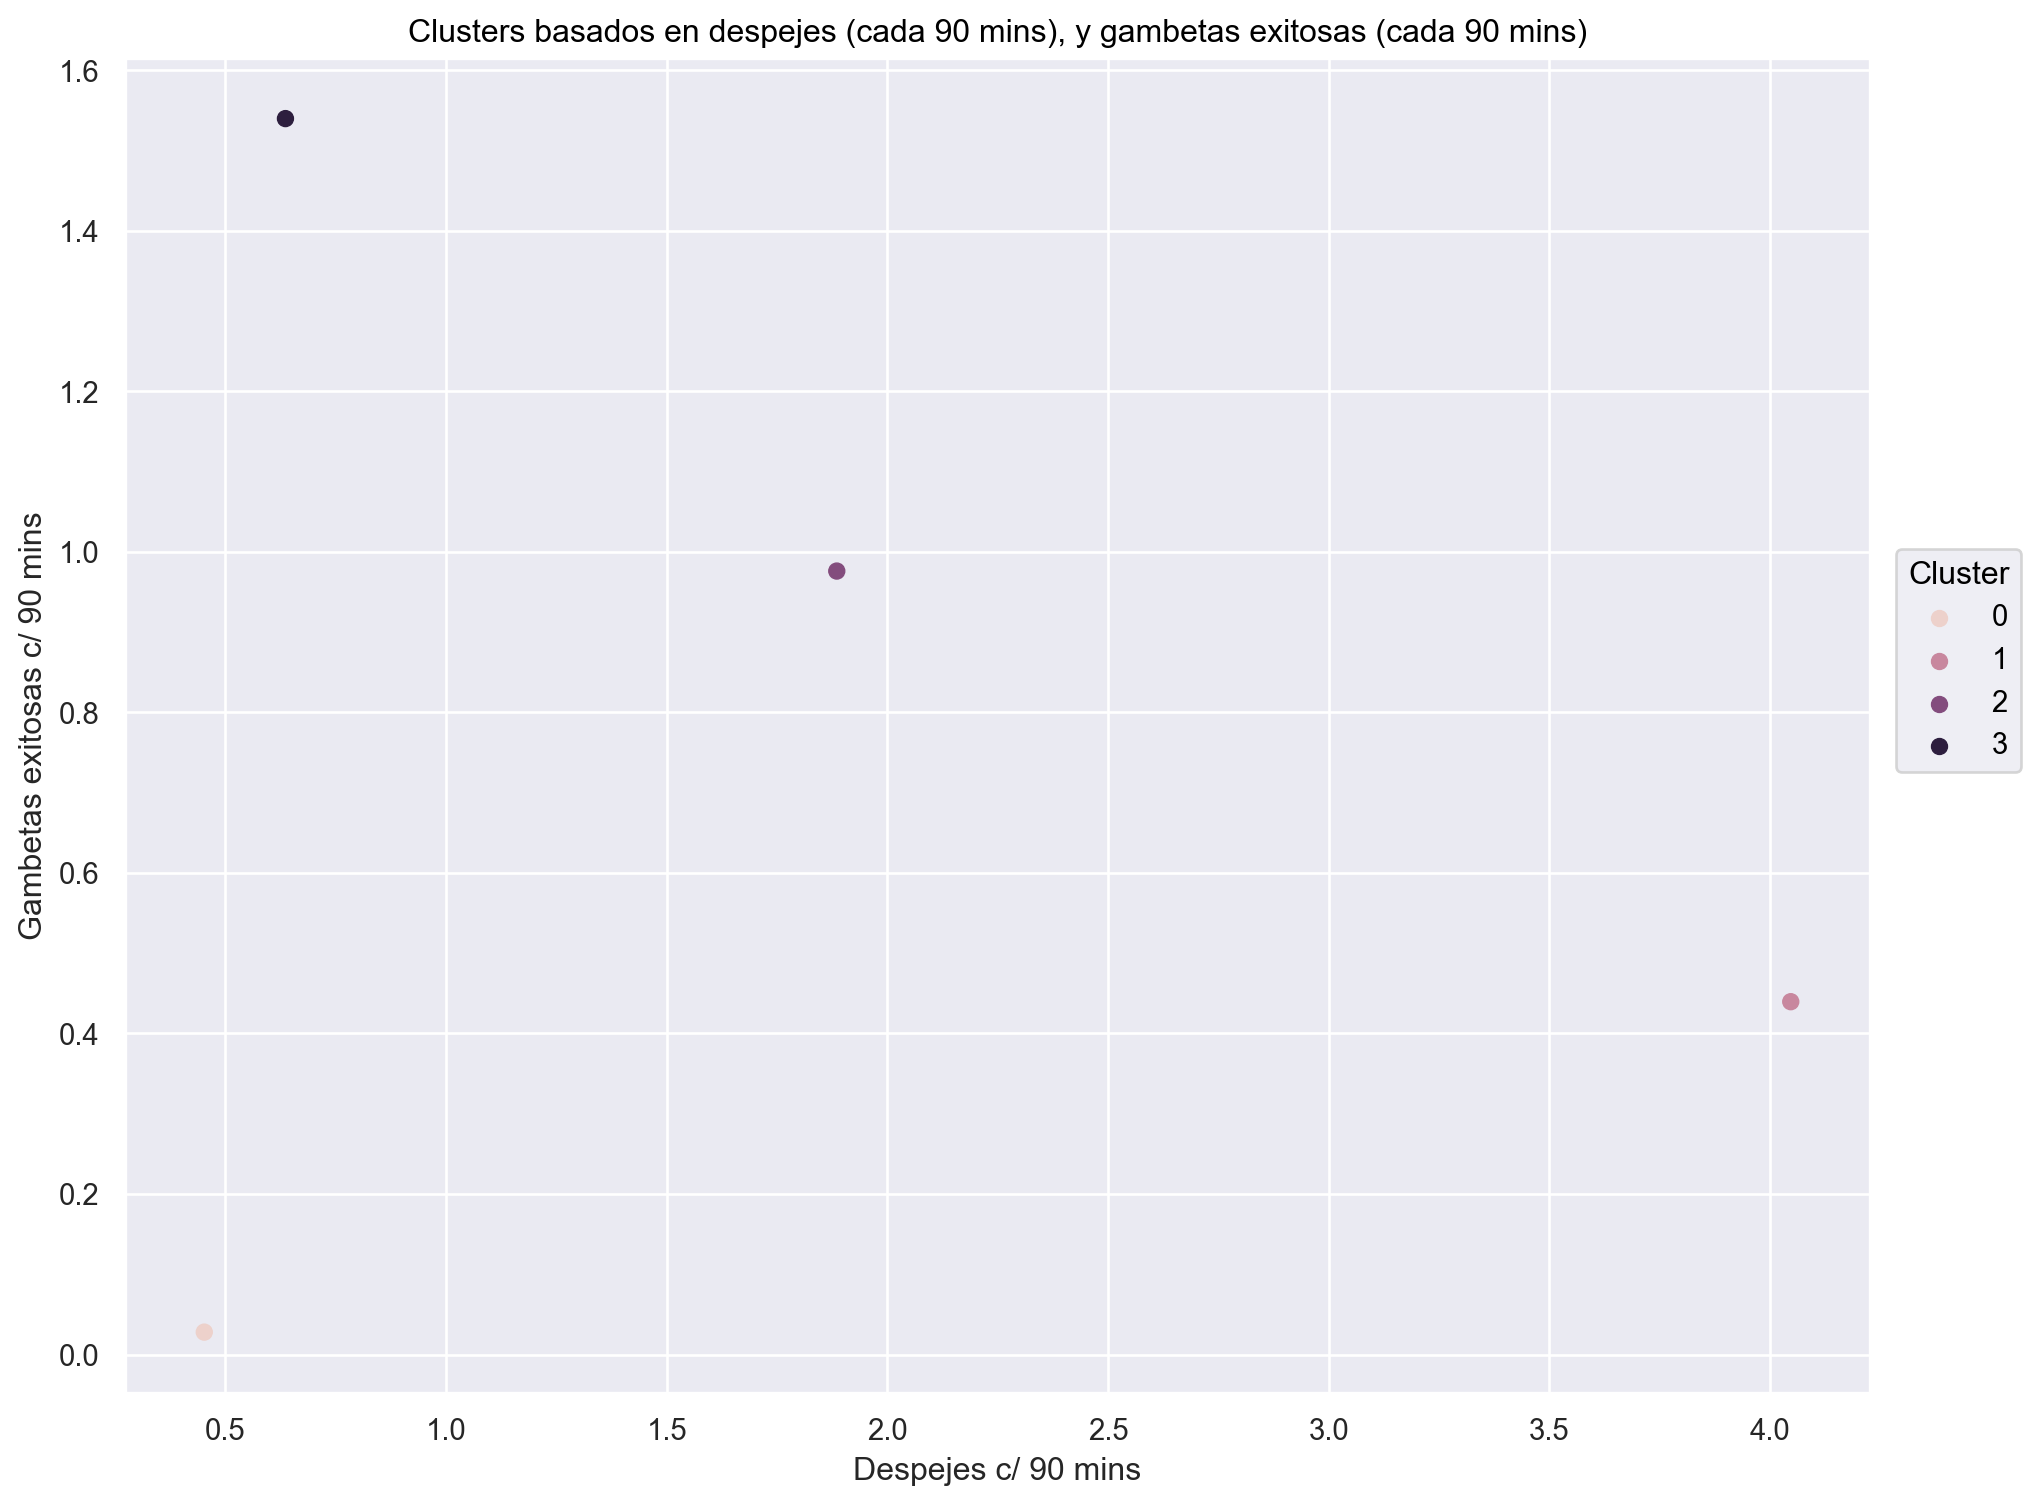

In [13]:
display(
    so.Plot(data=cluster_analisis, x="npxG+xA/90", y="Interceptions/90", color='Cluster')
    .add(so.Dot())
    .label(title="Clusters basados en expectativa de goles y asistencias (cada 90 mins), y pases progresivos (cada 90 mins)", x="Goles y asistencias esperados c/ 90 mins", y="Intercepciones c/ 90 mins")
    .layout(size=(10, 8))
)

display(
    so.Plot(data=cluster_analisis, x="Clearances/90", y="SuccDrib/90", color='Cluster')
    .add(so.Dot())
    .label(title="Clusters basados en despejes (cada 90 mins), y gambetas exitosas (cada 90 mins)", x="Despejes c/ 90 mins", y="Gambetas exitosas c/ 90 mins")
    .layout(size=(10, 8))
)

### Grafico 1: 
Lo más seguro es que el cluster 0 pertenezca a los arqueros, ya que no cuenta ni con un alto numero de goles y asistencias esperadas cada 90 minutos, ni con un alto numero de intercepciones cada 90 minutos. Esto quiere decir que no defiende ni ataca, por lo que nos quedan los arqueros. El cluster 3 es bastante facil de reconocer tambien ya que al ser el cluster que más alto valor tiene en el eje x podemos asegurar que muy probablemente este sea el de los delanteros. Por último nos quedan los clusters 1 y 2. Creemos que el 1 es el de los defensores ya que cuenta con un mayor valor en el eje de intercepciones y menor en el eje de goles y asistencias. El último cluster (2) es el de muy probablemente los mediocampistas (están bastante arriba en el eje y, y casi en el medio del eje x).
### Grafico 2:
Podemos confirmar que el cluster 0 pertenece a los arqueros y el cluster 3 a los delanteros. También podemos decir que el cluster 2 pertenece a los mediocampistas ya que están bastante equilibrados en ambos graficos. Por último, el cluster 1 sería el de los defensores ya que siempre tienen un valor alto en el eje más defensivo.
### Conclusión:
El cluster 0 tiene caracteristicas muy pobres en estos graficos porque ahi se encuentran los arqueros.
El cluster 1 tiene caracteristicas muy defensivas asique debe pertenecer a los defensores.
El cluster 2 es el de características más equilibradas, por lo que debe pertenecer a los medios.
Para concluir, el cluster 3 tiene características muy ofensivas (es decir pertenece a los delanteros).

### Objetivo
Para la cantidad de clusters observados en el ítem anterior, realizar un agrupamiento por k-medias, y colorear los puntos según las etiquetas obtenidas. ¿Coinci

### Enfoque
Se implementa el procedimiento descrito, documentando las decisiones de preprocesamiento y validando los resultados con visualizaciones y métricas cuando corresponde.


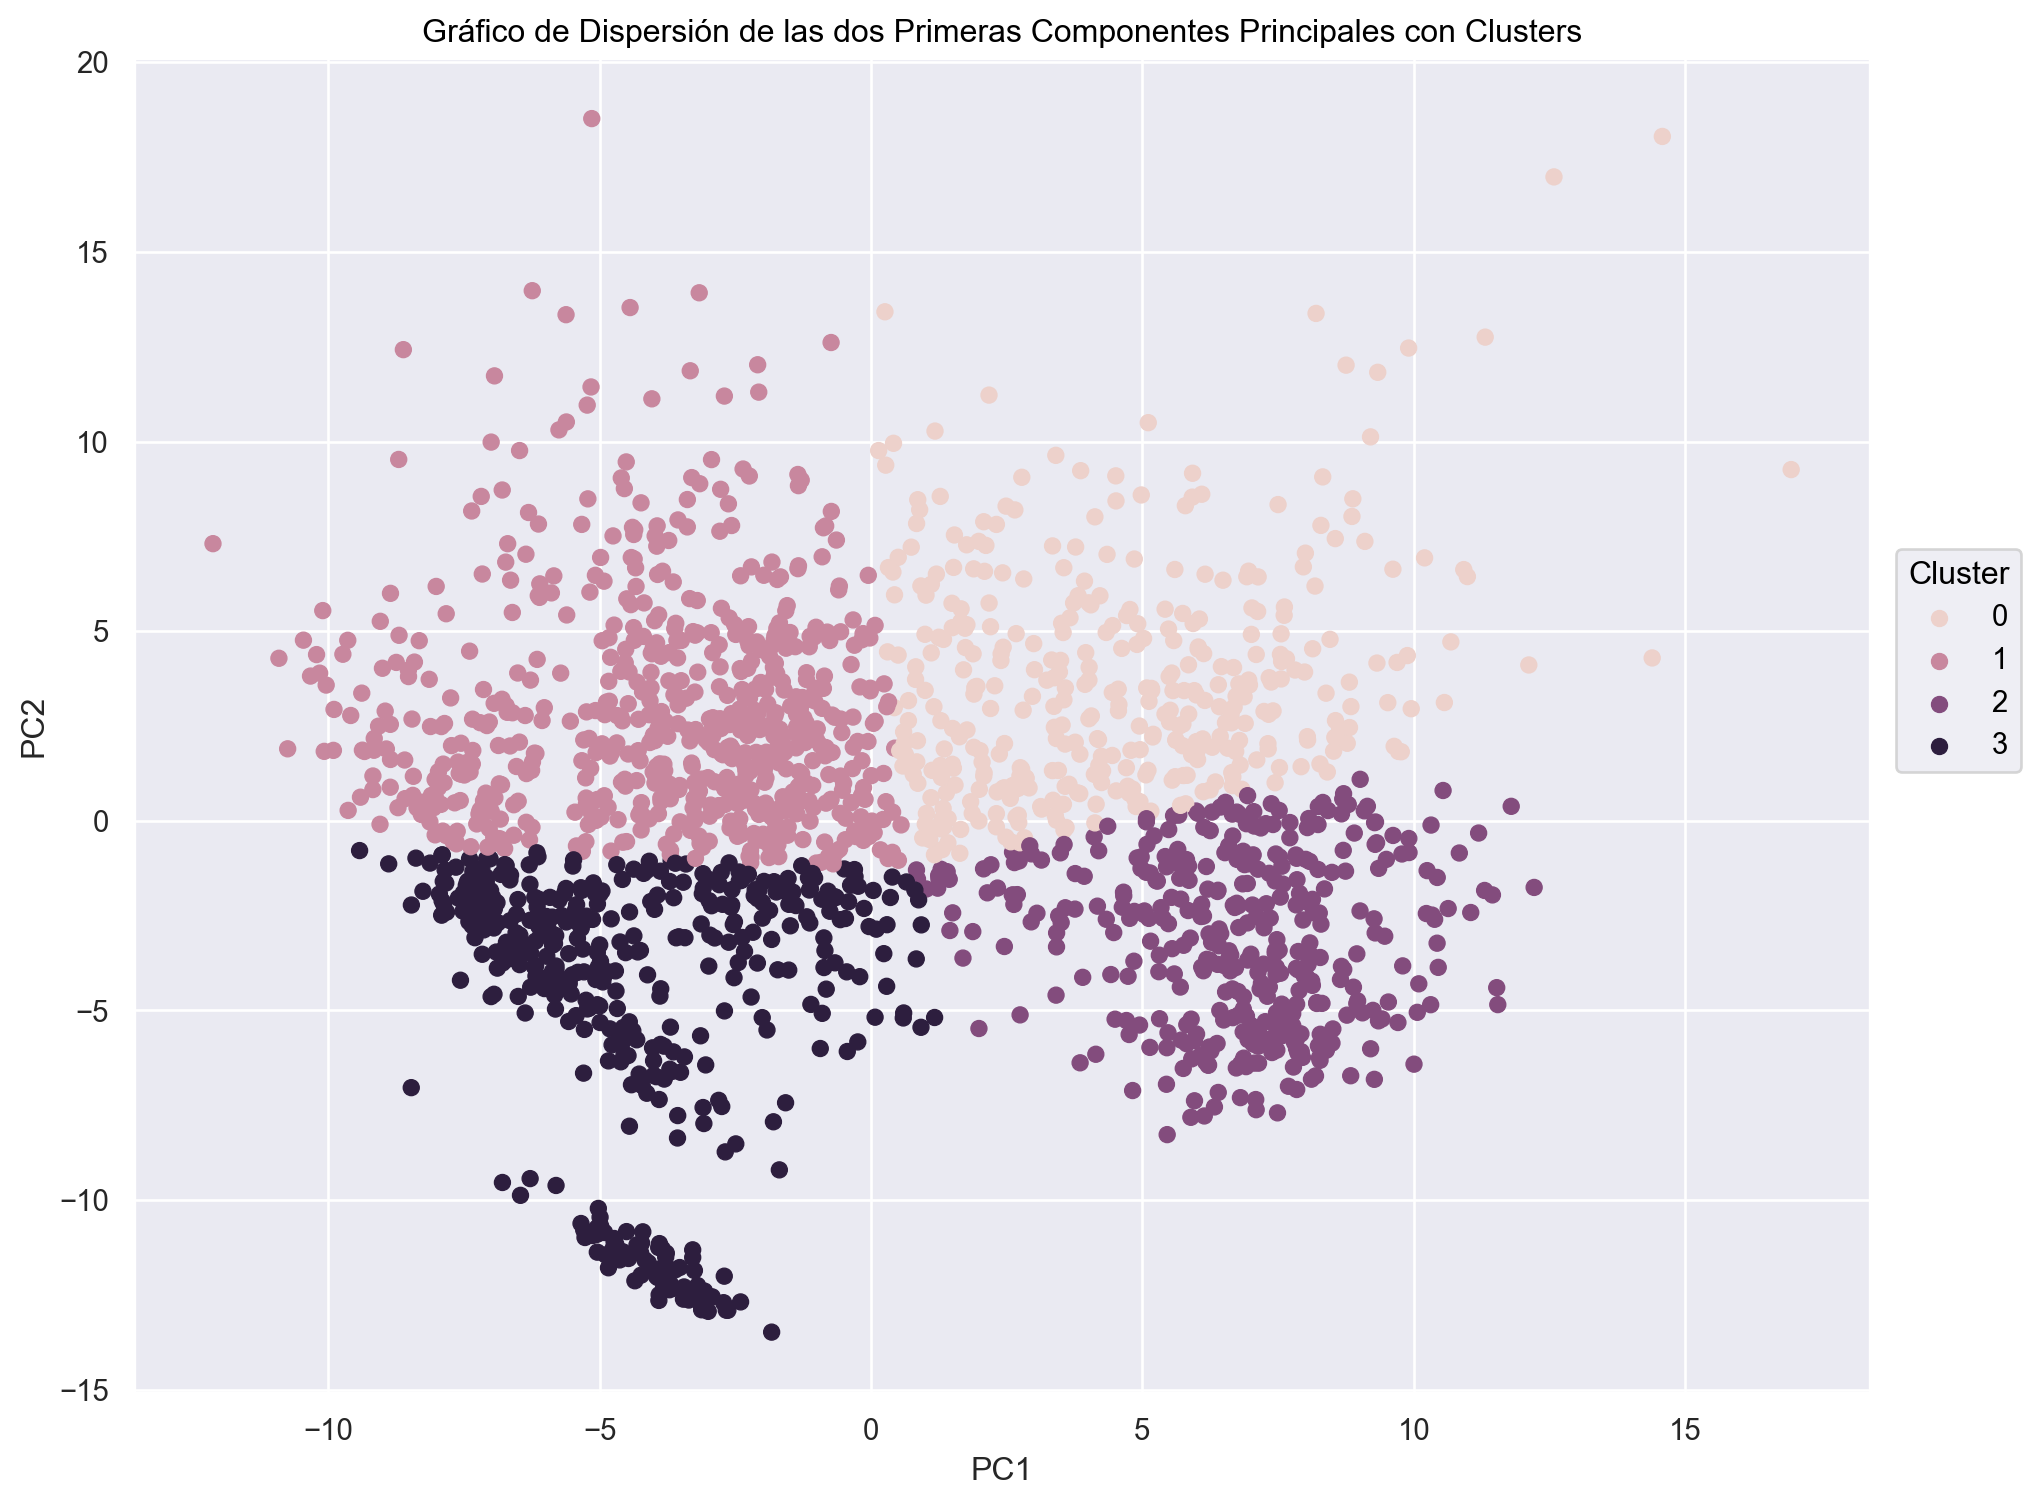

In [14]:
# Definimos la cantidad de clusters que buscamos
kmeans = KMeans(n_clusters=4)

# Ajustamos el modelo.
kmeans.fit(pca_data_num[["PC1","PC2"]])
labels = kmeans.labels_

# Añadimos los labels al dataframe
pca_data_num["Cluster"] = labels

(
    so.Plot(data=pca_data_num, x="PC1", y="PC2", color="Cluster")
    .add(so.Dot())
    .label(title="Gráfico de Dispersión de las dos Primeras Componentes Principales con Clusters")
    .layout(size=(10,8))
)

Luego de realizar un agrupamiento por k-medias, vemos que el resultado no es el que habiamos analizado anteriormente. Vemos que hay cuatro clusters pero no son los que vimos. Esto se debe a que el metodo de agrupamiento por k-medias consiste en encontrar centros para "k" clusters, y por lo tanto era esperable que los datos sean divididos de igual manera.

### Objetivo
Repetir el agrupamiento utilizando DBSCAN. ¿Cómo eligirían en este caso un valor de ε apropiado

### Enfoque
Se implementa el procedimiento descrito, documentando las decisiones de preprocesamiento y validando los resultados con visualizaciones y métricas cuando corresponde.


Antes de realizar el agrupamiento por DBSCAN debemos encontrar el mejor parametro para eps (distancia entre puntos). Para esto vamos a realizar el siguiente metodo:

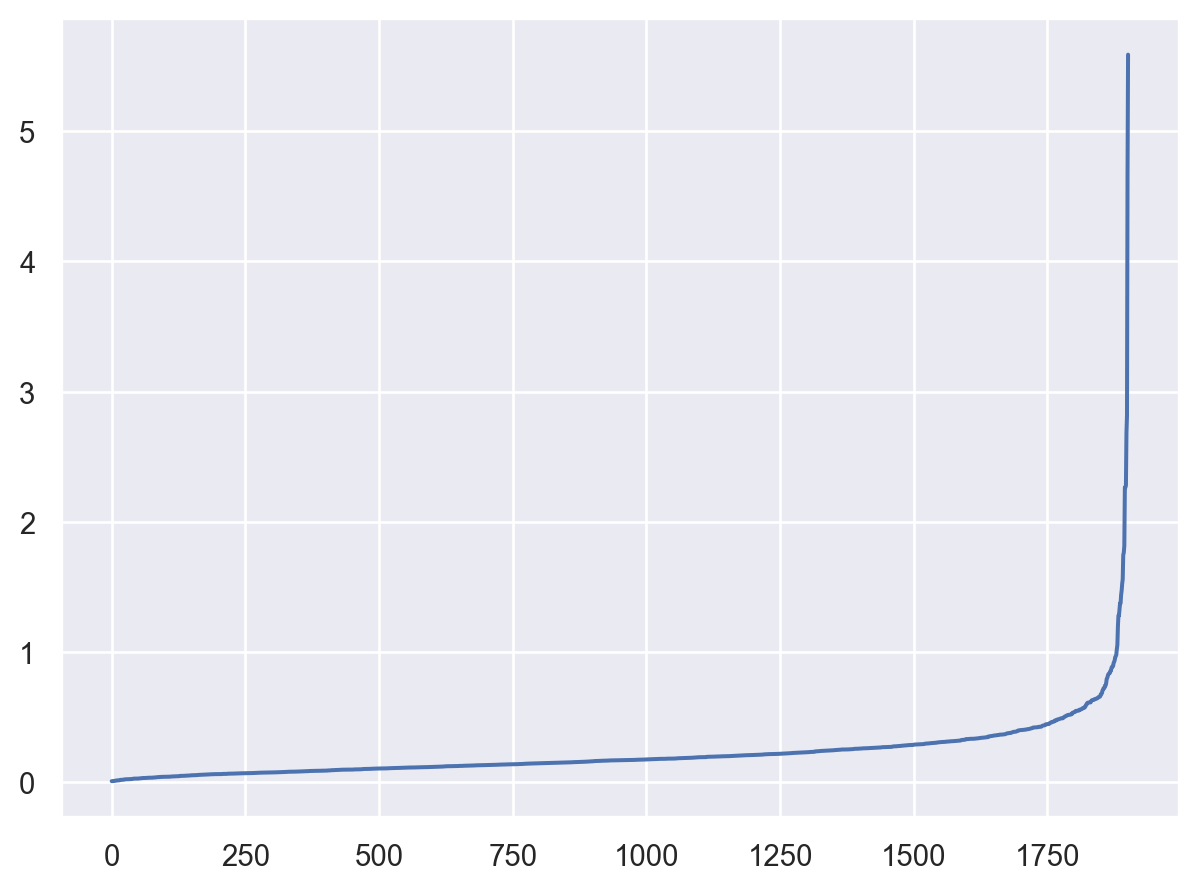

In [15]:
# Ponemos "n_neighbors=2" ya que cada punto se incluye a si mismo en la busqueda del más cercano.
cercanos = NearestNeighbors(n_neighbors=2)
cercanos = cercanos.fit(pca_data_num[["PC1","PC2"]])

distances, indices = cercanos.kneighbors(pca_data_num[["PC1","PC2"]])

# Ignoramos la primer distancia que es la que tiene el punto con él mismo.
distances = distances[:,1]

# Ordenamos en orden ascendente.
distances = np.sort(distances, axis=0)

(
    so.Plot(x = np.arange(len(distances)), y = distances)
    .add(so.Line())
)

Sabemos que el mejor valor es cuando se lleva a cabo la curva fuerte, es decir en aproximadamente 0.7. Procedemos a realizar el codigo.

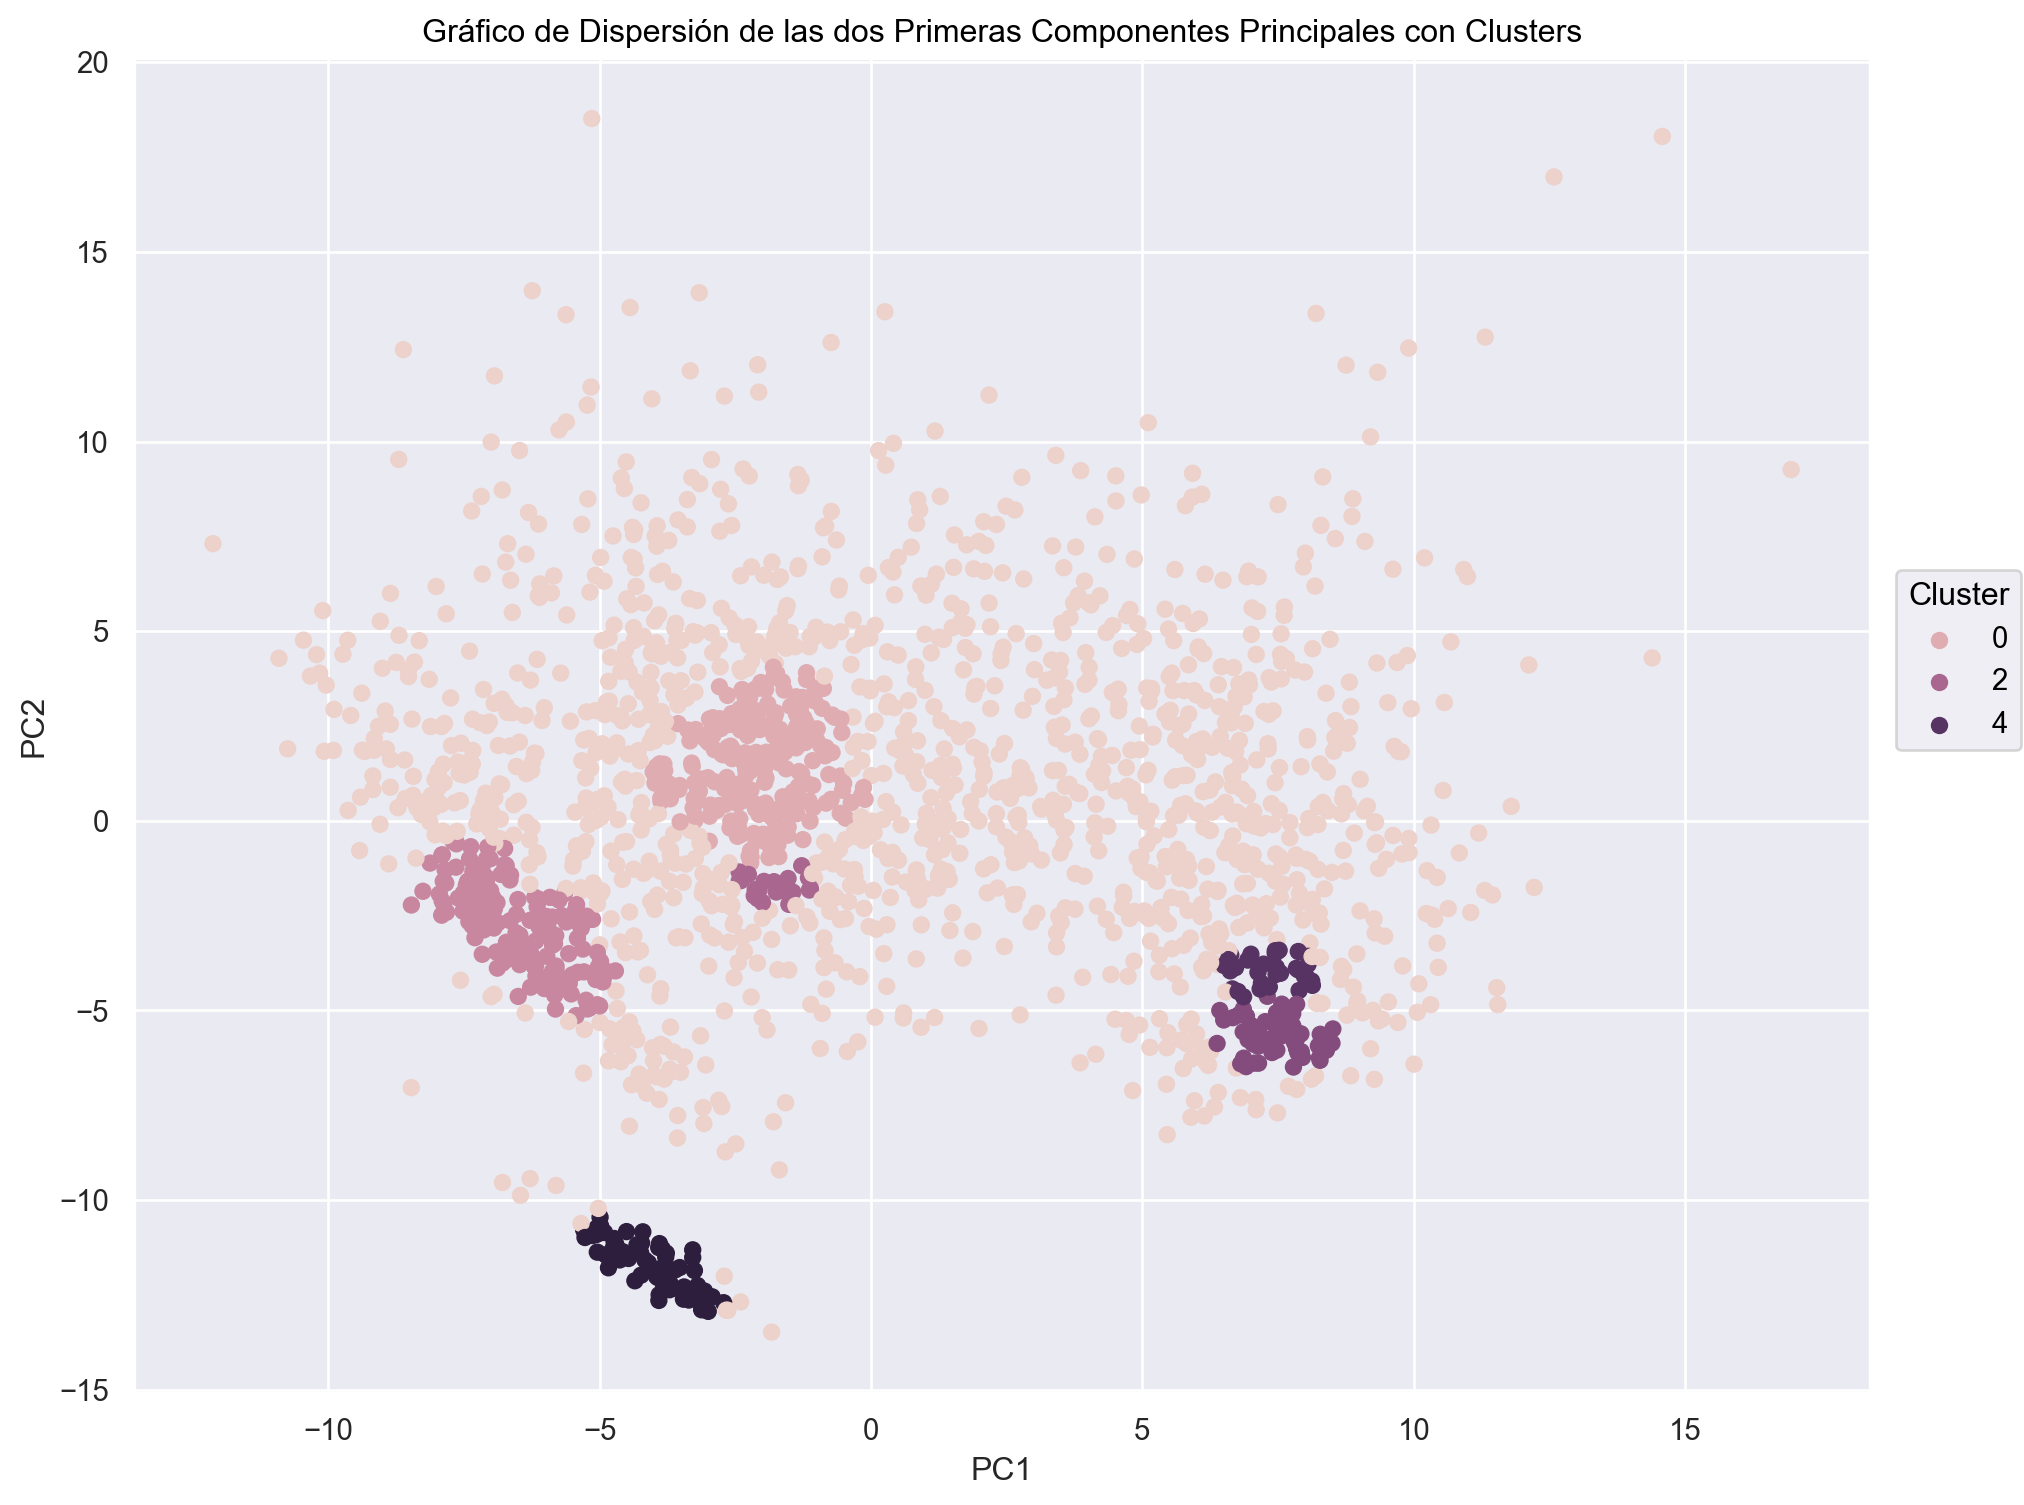

In [16]:
# Elegimos un valor para minimo de puntos bastante alto. Luego vamos a elegir uno más chico y comparamos.
dbscan = DBSCAN(eps=0.7, min_samples=25)
dbscan.fit(pca_data_num[["PC1","PC2"]])
labels = dbscan.labels_

pca_data_num["Cluster"] = labels

(
    so.Plot(data=pca_data_num, x="PC1", y="PC2", color="Cluster")
    .add(so.Dot())
    .label(title="Gráfico de Dispersión de las dos Primeras Componentes Principales con Clusters")
    .layout(size=(10,8))
)

In [17]:
print(f"El numero de clusters obtenidos con min_samples= 25 es: {pca_data_num['Cluster'].max()+1}")

El numero de clusters obtenidos con min_samples= 25 es: 6


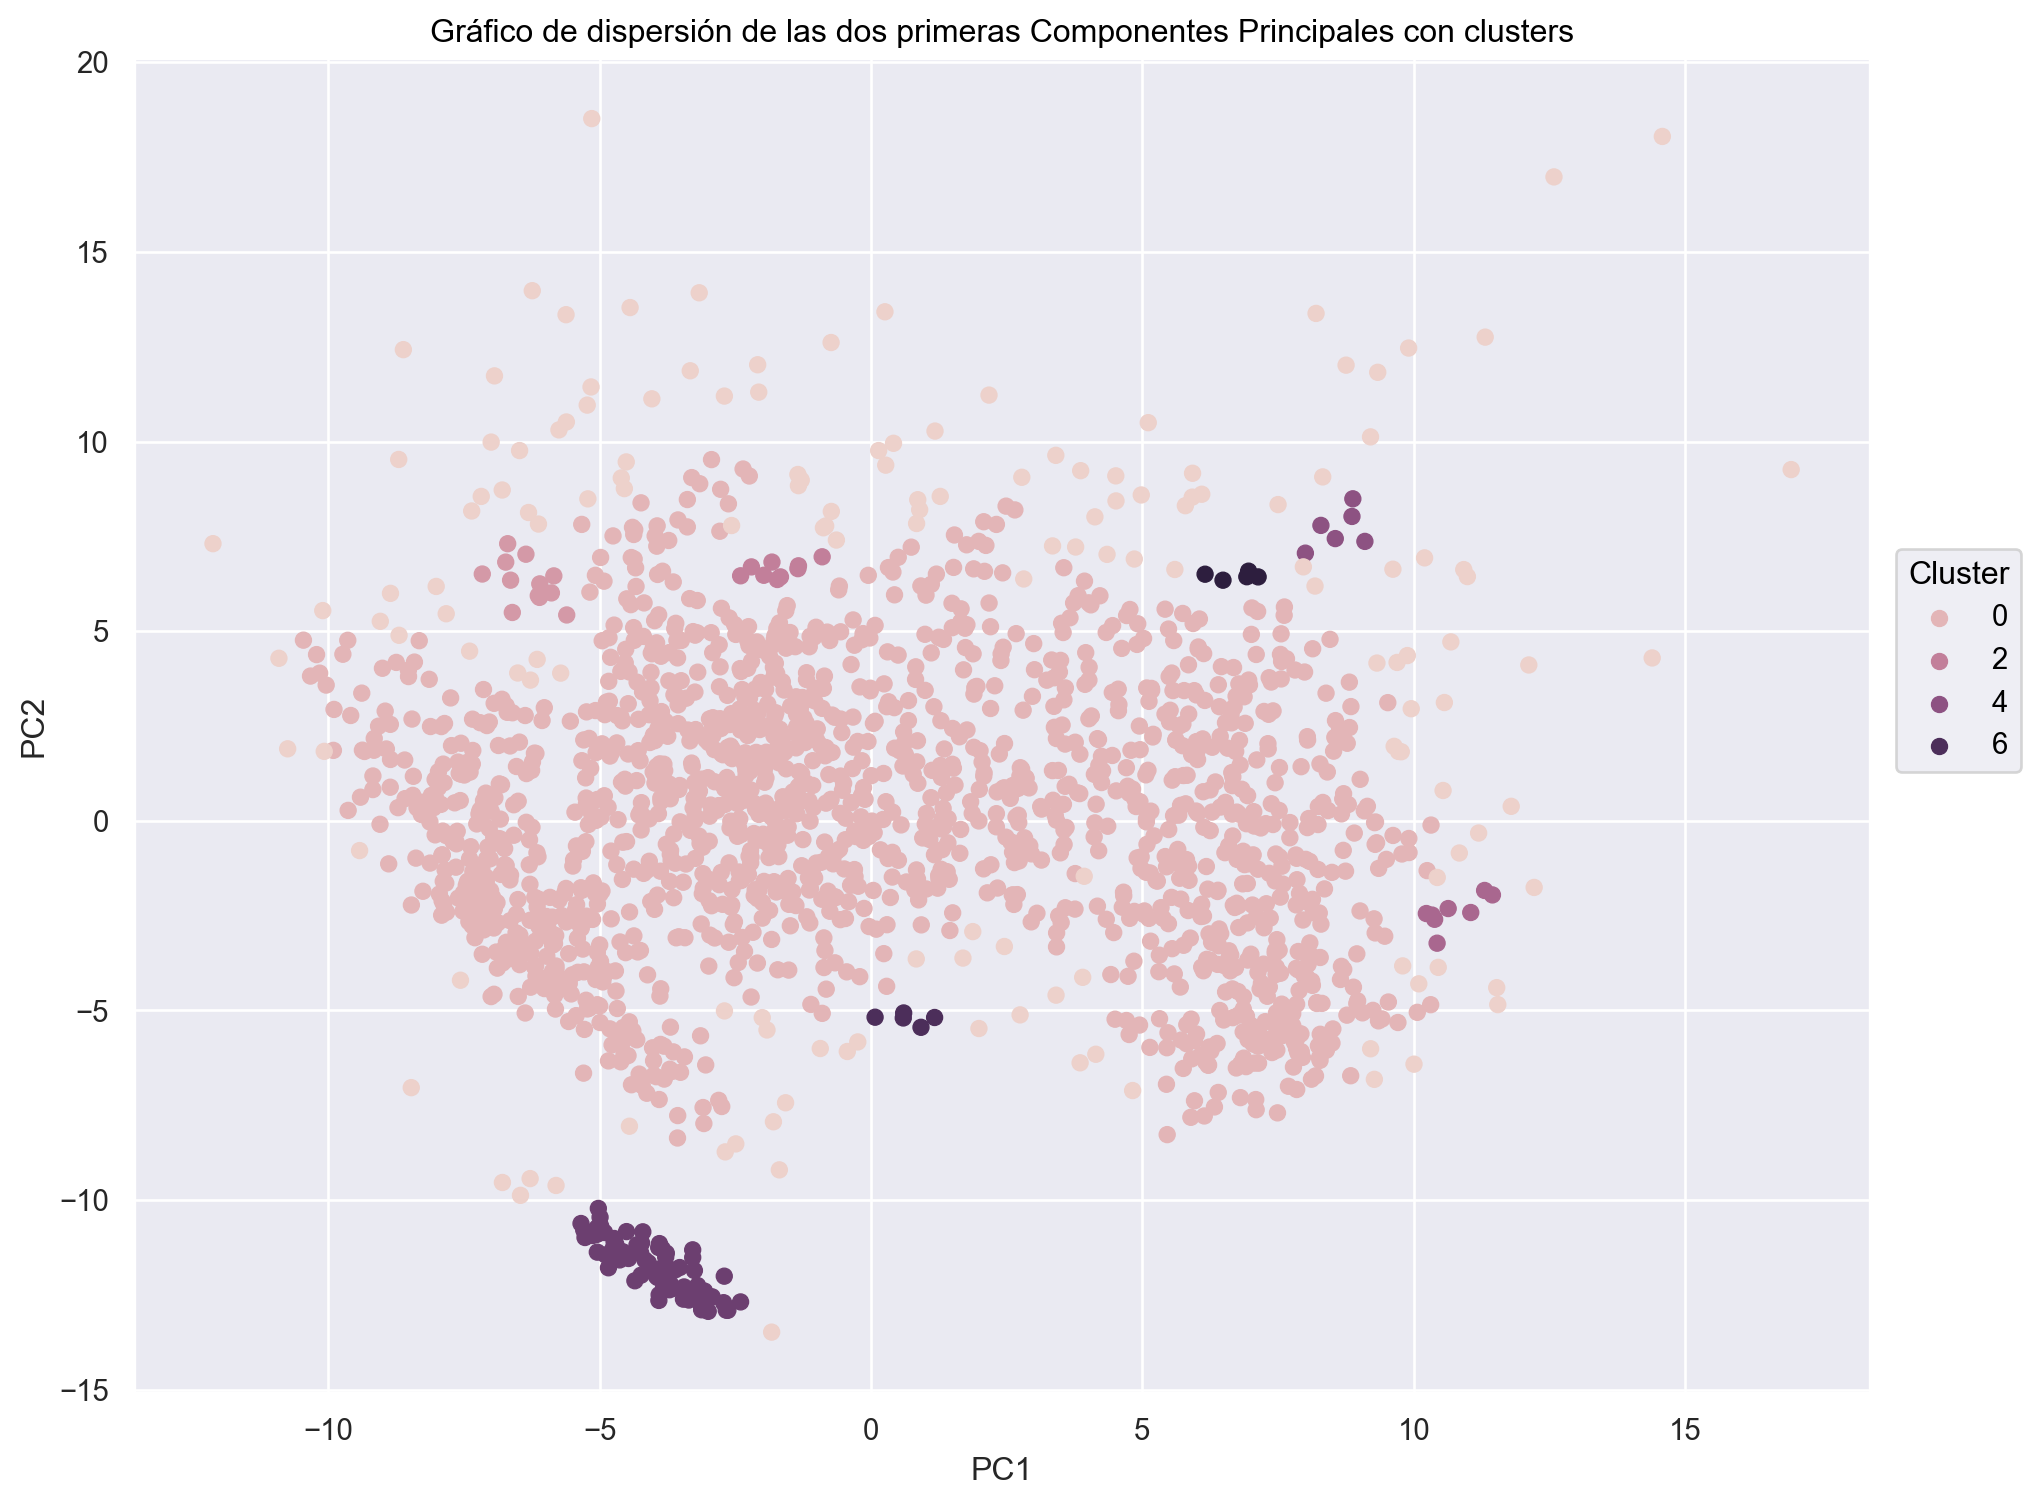

In [18]:
dbscan = DBSCAN(eps=0.7, min_samples=5)
dbscan.fit(pca_data_num[["PC1","PC2"]])
labels = dbscan.labels_

pca_data_num["Cluster"] = labels

(
    so.Plot(data=pca_data_num, x="PC1", y="PC2", color="Cluster")
    .add(so.Dot())
    .label(title="Gráfico de dispersión de las dos primeras Componentes Principales con clusters")
    .layout(size=(10,8))
)

In [19]:
print(f"El numero de clusters obtenidos con min_samples= 5 es: {pca_data_num['Cluster'].max()+1}")

El numero de clusters obtenidos con min_samples= 5 es: 8


Sacamos algunas conclusiones. En primer lugar, vemos que en ningun caso nos quedan los cuatro clusters que nos imaginabamos al principio. Luego, vemos que al usar un valor alto de puntos minimos, tenemos menor cantidad de clusters (6), y si usamos un valor más bajo tenemos una mayor cantidad de clusters (8), pero la diferencia es notablemente baja. Esto es algo esperado ya que al ver el grafico observamos que los puntos están sumamente cerca por lo que la cantidad minima de puntos no es algo que afecte demasiado.

### Objetivo
Aplicar DBSCAN para realizar agrupamiento utilizando como datos todas las variables originales en vez de solo las dos componentes principales, modificando los v

### Enfoque
Se implementa el procedimiento descrito, documentando las decisiones de preprocesamiento y validando los resultados con visualizaciones y métricas cuando corresponde.


Lo que entendí de este ejercicio es que tengo que buscar el hiperparametro epsilon pero ahora ajustando con todos los componentes principales y no solo con los 2 primeros.

In [20]:
data2 = StandardScaler().fit_transform(data_num)

# Aplicamos PCA
pca = PCA()

componentes = pca.fit_transform(data2)
pca_data_num2 = pd.DataFrame(data=componentes)

for i, col in enumerate(pca_data_num2.columns):
    pca_data_num2.rename(columns={col: f"PC{i}"}, inplace=True)

pca_data_num2.head()

PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
0 -2.822909  2.318714  0.519168  3.677139  1.321471  0.712077 -1.225213   
1 -6.910470 -1.291152  0.173956 -2.172071  0.704618  0.111674  1.910582   
2 -6.613005 -3.676448 -0.528323 -0.958413  0.654249  1.346843  3.550516   
3 -5.206428 -1.826636  0.805103 -0.331089  0.693911  1.363821 -0.068386   
4 -7.481644  1.672219 -1.527066 -1.005088  0.899246  0.636097  0.956313   

        PC7       PC8       PC9  ...      PC97      PC98      PC99     PC100  \
0 -0.460353 -0.175032  1.577985  ...  0.007467  0.000867  0.002180  0.010296   
1  0.295322  0.017932  1.995435  ... -0.007669 -0.001022 -0.000062  0.005960   
2 -1.180669 -0.018896 -0.474673  ...  0.029980 -0.000693  0.002718  0.004271   
3 -0.506660 -0.103500 -0.488713  ... -0.017958  0.002026 -0.010145 -0.004070   
4 -0.528413  0.327889  1.520914  ...  0.005158  0.005174 -0.004369 -0.000830   

      PC101     PC102     PC103     PC104     PC105     PC106  
0 -0.006172 -0.007447 -0.002198 -0.000116  0.005589  0.000409  
1 -0.002533  0.000758 -0.006287  0.006990 -0.002511  0.001966  
2 -0.004122 -0.008957 -0.000104 -0.000483 -0.001403  0.001955  
3 -0.006905  0.004739  0.003973  0.001145  0.001486  0.001988  
4  0.001714 -0.001698  0.002254  0.003605  0.006687  0.000302  

[5 rows x 107 columns]

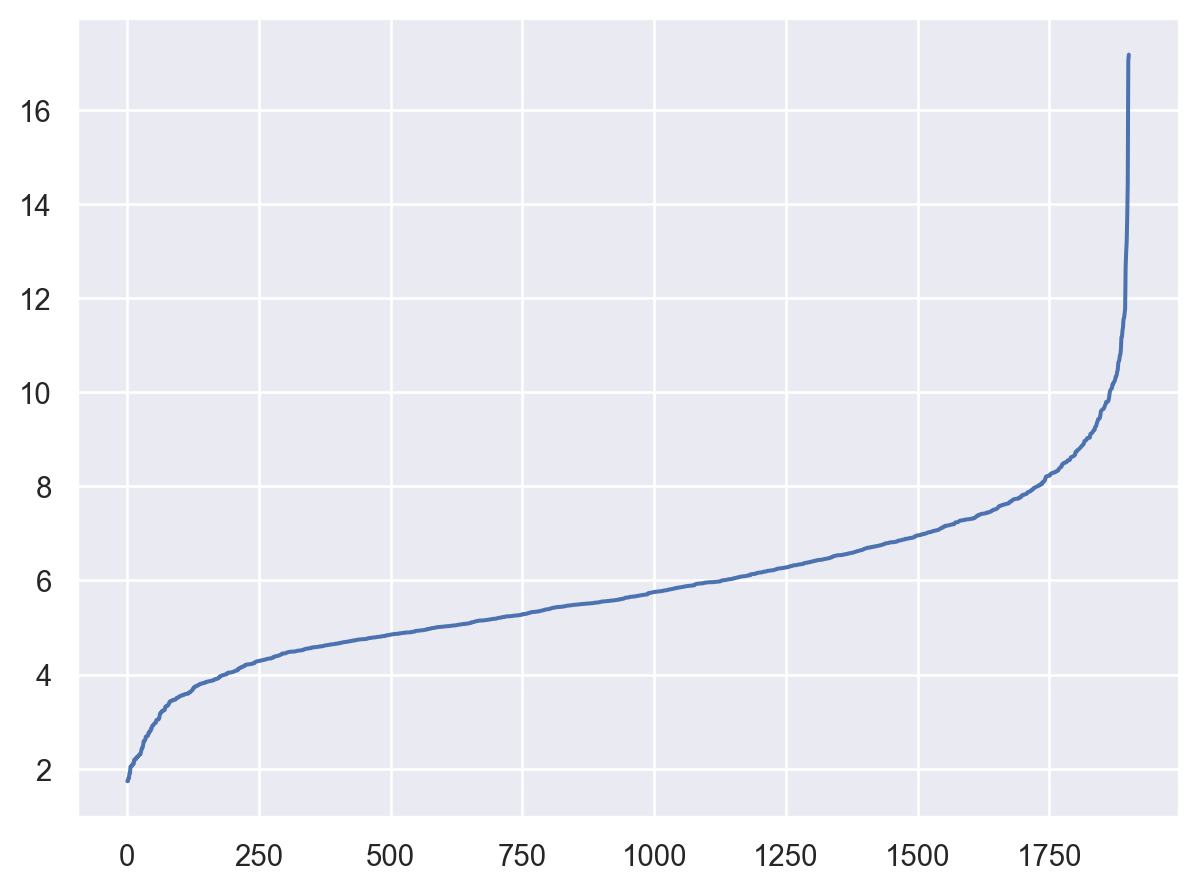

In [21]:
cercanos = NearestNeighbors(n_neighbors=2)

cercanos = cercanos.fit(pca_data_num2[pca_data_num2.columns])

distances, indices = cercanos.kneighbors(pca_data_num2[pca_data_num2.columns])

distances = distances[:,1]

distances = np.sort(distances, axis=0)

(
    so.Plot(x = np.arange(len(distances)), y = distances)
    .add(so.Line())
)

Usamos hiperparametro = 3 y luego hiperparametro = 9.

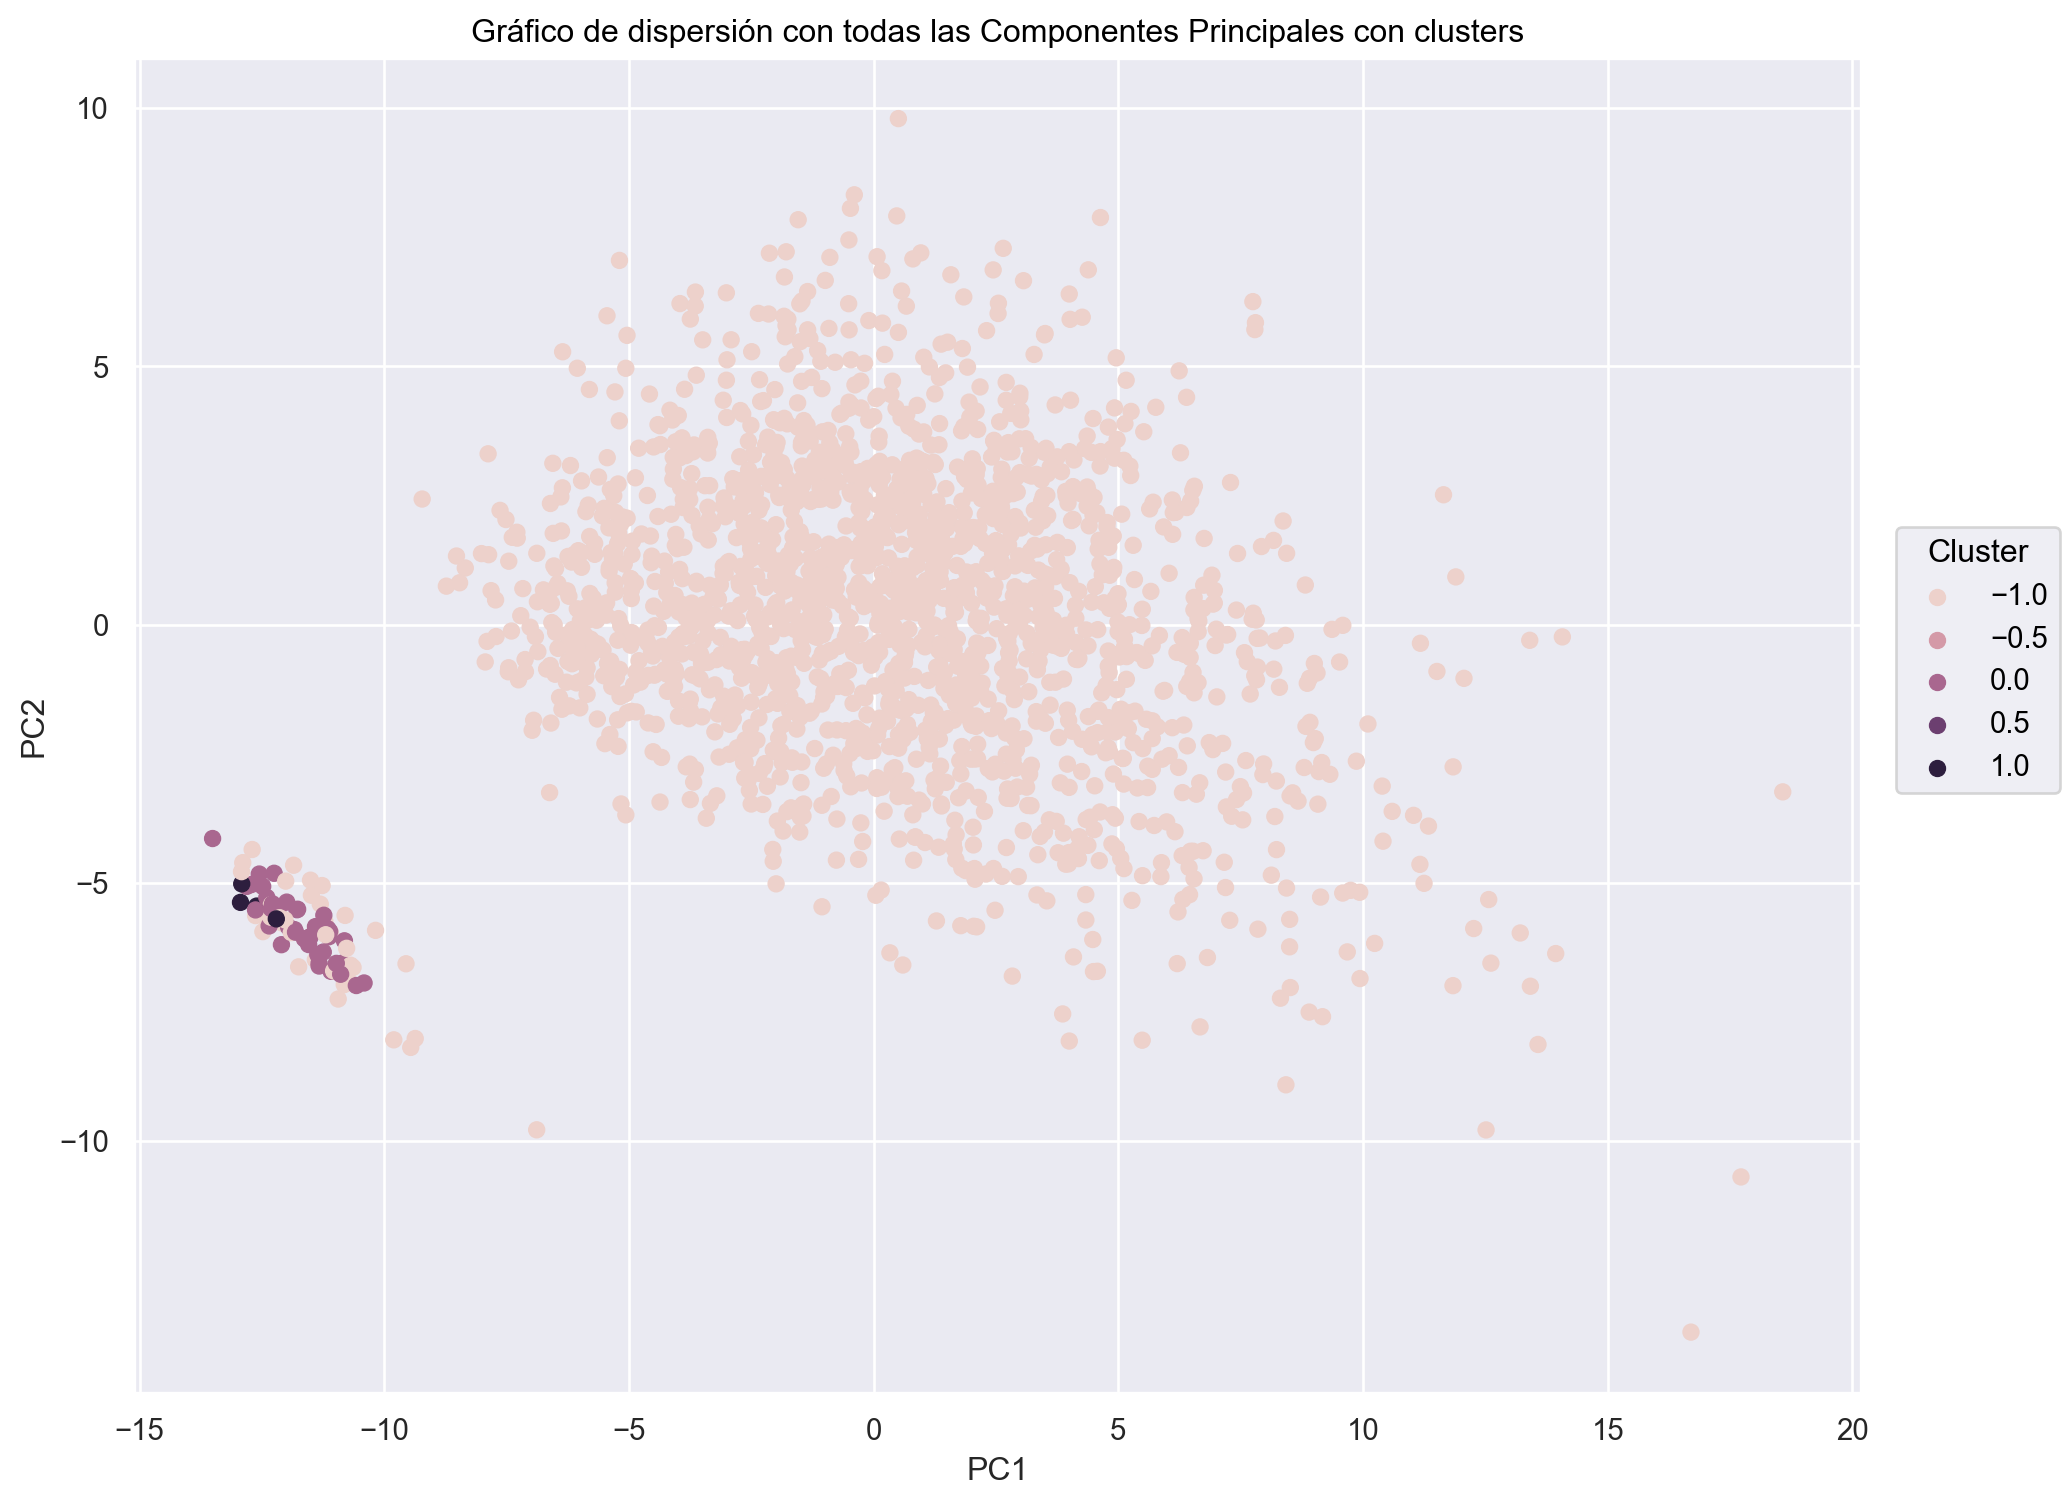

In [22]:
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan.fit(pca_data_num2[pca_data_num2.columns])
labels = dbscan.labels_

pca_data_num2["Cluster"] = labels

(
    so.Plot(data=pca_data_num2, x="PC1", y="PC2", color="Cluster")
    .add(so.Dot())
    .label(title="Gráfico de dispersión con todas las Componentes Principales con clusters")
    .layout(size=(10,8))
)

In [23]:
print(f"El numero de clusters obtenidos con min_samples= 5 es: {pca_data_num2['Cluster'].max()+1}")

El numero de clusters obtenidos con min_samples= 5 es: 2


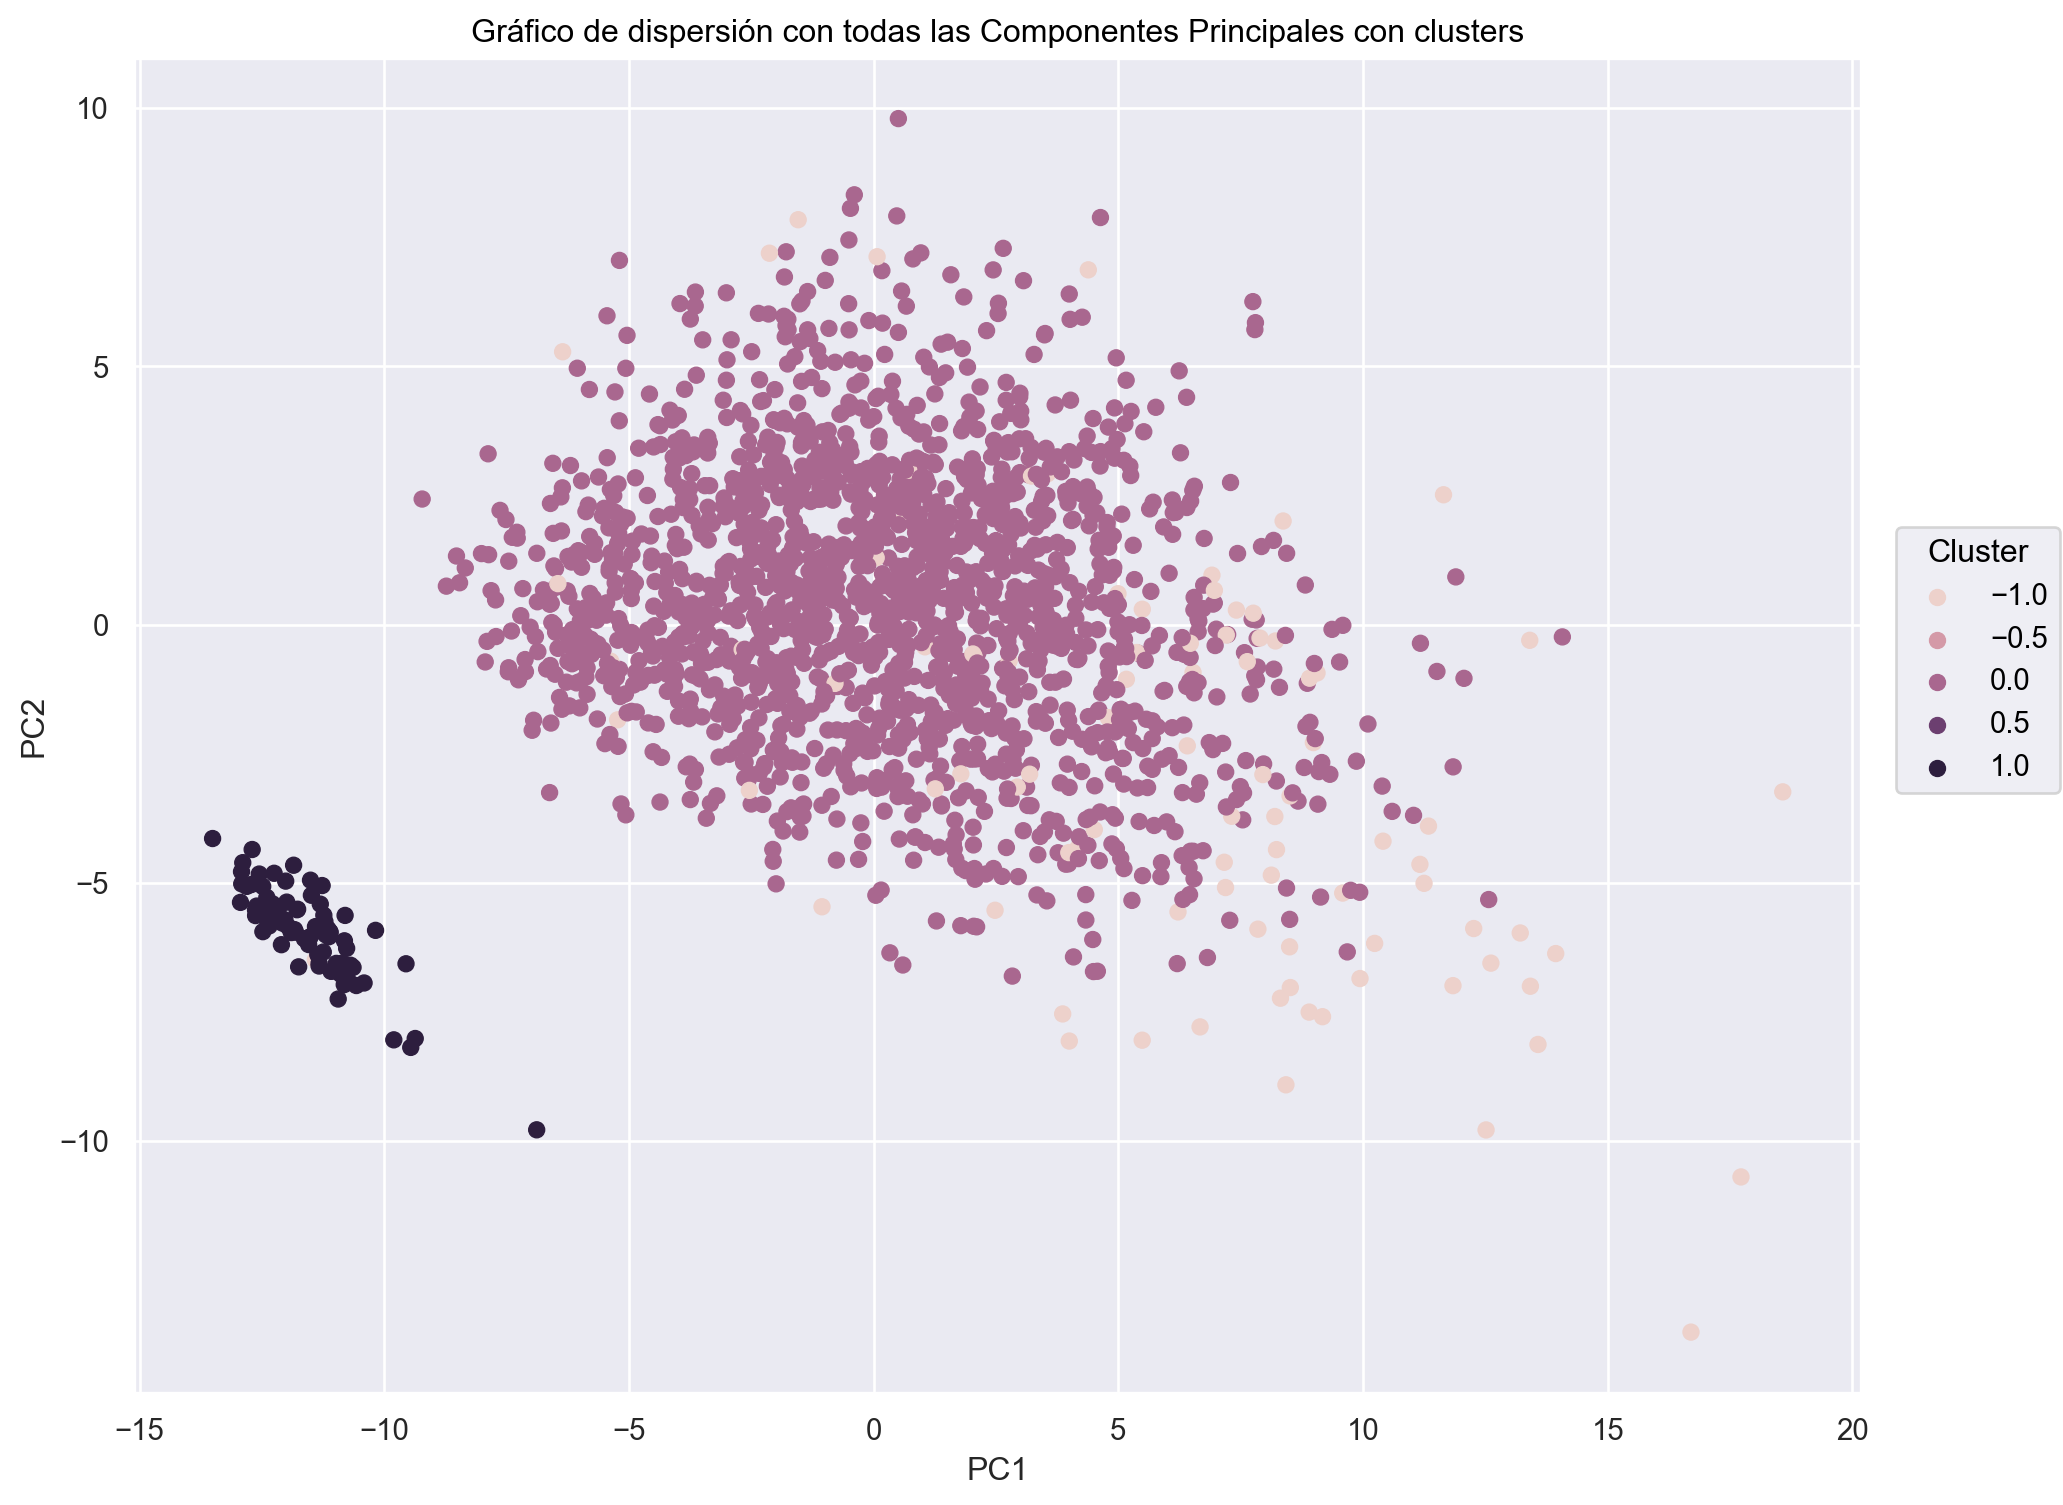

In [24]:
dbscan = DBSCAN(eps=9, min_samples=15)
dbscan.fit(pca_data_num2[pca_data_num2.columns])
labels = dbscan.labels_

pca_data_num2["Cluster"] = labels

(
    so.Plot(data=pca_data_num2, x="PC1", y="PC2", color="Cluster")
    .add(so.Dot())
    .label(title="Gráfico de dispersión con todas las Componentes Principales con clusters")
    .layout(size=(10,8))
)

In [25]:
print(f"El numero de clusters obtenidos con min_samples= 5 es: {pca_data_num2['Cluster'].max()+1}")

El numero de clusters obtenidos con min_samples= 5 es: 2


### Objetivo
anterior.

### Enfoque
Se implementa el procedimiento descrito, documentando las decisiones de preprocesamiento y validando los resultados con visualizaciones y métricas cuando corresponde.


### Clasificación

##

Ahora queremos poder predecir la posición en la que juega cada jugador según sus datos estadísticos utilizando KNN. En la columna Pos encontramos la posición de los jugadores. Para la mayoría de los jugadores se indica una única posición pero algunos jugadores tienen dos posiciones. Para simplificar el análisis vamos a considerar una única posición por jugador.

### Objetivo
Definir la variable Pos_filt que es la columna Pos, pero donde los jugadores deben tener una sola posición (pueden quedarse sólo con la primera posición de cada

### Enfoque
Se implementa el procedimiento descrito, documentando las decisiones de preprocesamiento y validando los resultados con visualizaciones y métricas cuando corresponde.


In [26]:
# Definimos la variable Pos_filt que son los datos de la columna Pos pero cada jugador tiene solo una posición.
futbol['Pos_filt'] = futbol['Pos'].str.split(',').str[0] #dividimos la cadena de posiciones que estan separadas (de haber 2) por una coma y nos quedamos solo con la primera de las Pos.
futbol[['Player','Pos','Pos_filt']]

Player    Pos Pos_filt
0     Patrick van Aanholt     DF       DF
1        Yunis Abdelhamid     DF       DF
2         Pape Abou Cisse     DF       DF
3           David Abraham     DF       DF
4        Francesco Acerbi     DF       DF
...                   ...    ...      ...
1897        Reinhold Yabo  MF,FW       MF
1898          Amin Younes  MF,FW       MF
1899      Mattia Zaccagni  MF,FW       MF
1900         Arber Zeneli  MF,FW       MF
1901        Mehdi Zerkane  MF,FW       MF

[1902 rows x 3 columns]

### Objetivo
Dividir el DataFrame data_num y la Series Pos_filt utilizando un 80% para entrenamiento y un 20% para testeo.

### Enfoque
Se implementa el procedimiento descrito, documentando las decisiones de preprocesamiento y validando los resultados con visualizaciones y métricas cuando corresponde.


In [27]:
X = data_num
y = futbol['Pos_filt']
X = MinMaxScaler().set_output(transform='pandas').fit_transform(X)
#Separo el DataFrame data_num y la Serie Pos_filt en entrenamineto (80%) y testeo(20%)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state= 42)

### Objetivo
Aplicar un esquema de validación en el conjunto de entrenamiento para seleccionar el valor óptimo de K. (Esto puede demorar mucho si prueban muchos valores de K

### Enfoque
Se implementa el procedimiento descrito, documentando las decisiones de preprocesamiento y validando los resultados con visualizaciones y métricas cuando corresponde.


In [28]:
cv_k_scores = []
for K in range(1,21): # probamos con K del 1 al 20
    neighbor = KNeighborsClassifier(n_neighbors=K) 
    scores = cross_val_score(neighbor, X_train, y_train) #Hacemos validación cruzada con cada K en los conjuntos de entrenamiento.
    cv_k_scores.append(scores.mean()) # Hace un promedio de los valores de score obtenidos en las particiones del cross validation.
    print(K,scores.mean())

1 0.8981039689387403
2 0.8941609145815358
3 0.9079637618636756
4 0.9112532355478861
5 0.91059318377912
6 0.9138891285591028
7 0.9158563416738568
8 0.9184900776531493
9 0.9145383951682484
10 0.9132269197584124
11 0.9125690250215703
12 0.9112510785159621
13 0.9125668679896461
14 0.9099352890422778
15 0.9092817083692839
16 0.9066479723899914
17 0.9105910267471959
18 0.9112510785159621
19 0.9112510785159621
20 0.9125647109577223


Vemos que el K optimo es el K=8. Ahora vamos a chequear nuestra elección.

In [29]:
K_optimo = cv_k_scores.index(max(cv_k_scores)) + 1
print("el K óptimo es K =", K_optimo)

el K óptimo es K = 8


### Objetivo
Para el valor de K obtenido, ¿cuál es el porcentaje de aciertos en el conjunto de testeo

### Enfoque
Se implementa el procedimiento descrito, documentando las decisiones de preprocesamiento y validando los resultados con visualizaciones y métricas cuando corresponde.


In [30]:
# Entrenamos el modelo con el valor óptimo de K
neighbor = KNeighborsClassifier(n_neighbors=K_optimo)
neighbor.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = neighbor.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
print("Porcentaje de acierto en el conjunto de testeo: {:.2f}%".format(accuracy * 100))

0.910761154855643
Porcentaje de acierto en el conjunto de testeo: 91.08%


### Recomendaciones de jugadores

#### 8) Trabajamos ahora con el dataset transfermarkt_fbref_201920.csv que incluye la valuación de los jugadores. Una de las aplicaciones más comunes de análisis de datos en el fútbol es para obtener recomendaciones de jugadores a comprar.

In [31]:
data = pd.read_csv("transfermarkt_fbref_201920.csv", delimiter=";")
data.head()

Column1                 player nationality position   squad  age  \
0       21  Martin Aguirregabiria      es ESP       DF  Alavés   23   
1      390           Oliver Burke     sco SCO    MF,FW  Alavés   22   
2      430       Ví­ctor Camarasa      es ESP       MF  Alavés   25   
3      737           Rubén Duarte      es ESP       DF  Alavés   23   
4      770            Rodrigo Ely      br BRA       DF  Alavés   25   

   birth_year    value  height                      position2  ... Pts/G  \
0        1996  4000000     178          Defender - Right-Back  ...  1.03   
1        1997  4000000     188         Forward - Right Winger  ...  1.03   
2        1994  4000000     183  Midfielder - Central Midfield  ...  1.03   
3        1995  4000000     172           Defender - Left-Back  ...  1.03   
4        1993  1000000     188         Defender - Centre-Back  ...  1.03   

     xG   xGA  xGDiff  xGDiff/90  Attendance  CL  WinCL  CLBestScorer   Season  
0  37.0  53.2   -16.2      -0.43      12,177   0      0           0.0  201920#  
1  37.0  53.2   -16.2      -0.43      12,177   0      0           0.0  201920#  
2  37.0  53.2   -16.2      -0.43      12,177   0      0           0.0  201920#  
3  37.0  53.2   -16.2      -0.43      12,177   0      0           0.0  201920#  
4  37.0  53.2   -16.2      -0.43      12,177   0      0           0.0  201920#  

[5 rows x 400 columns]

### Objetivo
En 2021 Messi fue transferido del Barcelona al PSG. Basándose en los datos disponibles, recomendarle a Barcelona un jugador de características similares a Messi

### Enfoque
Se implementa el procedimiento descrito, documentando las decisiones de preprocesamiento y validando los resultados con visualizaciones y métricas cuando corresponde.


Para encontrar jugadores con características parecidas a Messi vamos a utilizar PCA teniendo en cuenta solo las variables numericas. Luego de esos jugadores vamos a ver cual tiene un valor de mercado menor al de Messi y juega en una posición similar.

In [32]:
data2 = data.set_index("player")

In [33]:
# Sacamos las columnas con valores no numericos
X = data2.drop(columns=["nationality","position","squad","position2", "foot", "league","Season"])

# Le sacamos las comas a los numeros dado que sino nos provocaba un error al correr el codigo
X = X.map(lambda x: float(str(x).replace(',', '')) if isinstance(x, str) else x)
X = X.dropna(axis=1)

# Aplicamos PCA ajustando a un 90%
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X)

# Creamos el nuevo dataframe
data2_pca = pd.DataFrame(X_pca, index=data2.index)

In [34]:
jugadores_elegidos = []

# Definimos los datos de Messi y el rango que le daremos al "reemplazo"
stat_messi = data2_pca.loc["Lionel Messi", 0]
limite_inf = stat_messi * 0.75
limite_sup = stat_messi * 1.25

# Iteramos sobre cada jugador
for jugador in data2_pca.index:
        
    if jugador == "Lionel Messi":
        continue
    
    stats_cercanas_a_messi = 0

    stat_jugador = data2_pca.loc[jugador, 0]
    
    
    # Queremos solo los valores escalares
    if not isinstance(stat_jugador, (int, float)):
       continue
    
    # Verificamos el nuevo jugador entre en nuestros límites
    if limite_inf <= stat_jugador <= limite_sup:
        jugadores_elegidos.append(jugador)
        
        
print(jugadores_elegidos)

['Jan Oblak', 'Antoine Griezmann', 'Jadon Sancho', 'Trent Alexander-Arnold', 'Sadio Mané', 'Mohamed Salah', 'Kevin De Bruyne', 'Raheem Sterling', 'Neymar', 'Harry Kane']


Podemos ver que los jugadores que entran en nuestro rango son: Oblak, Griezmann, Sancho, Alexander-Arnold, Mané, Salah, De Bruyne, Sterling, Neymar y Kane. De estos, vamos a descartar a Oblak y Alexander-Arnold ya que son arquero y defensor respectivamente. Vamos a ver el valor de mercado de los demás y luego vamos a dar el elegido para ser el reemplazo de Lionel Messi.

In [35]:
valor_messi = data2.loc["Lionel Messi", "value"]

jugadores = []

for jugador in ["Antoine Griezmann","Jadon Sancho","Sadio Mané","Mohamed Salah","Kevin De Bruyne","Harry Kane","Raheem Sterling","Neymar"]:
    valor_jugador = data2.loc[jugador, "value"]
    if valor_jugador < valor_messi:
        jugadores.append(jugador)

print(jugadores)

['Antoine Griezmann']


Luego de finalizar el análisis, podemos decir que el reemplazo de Messi debe ser Antoine Griezmann, ya que es el único jugador que cumplió con todos los requisitos solicitados, y además juega en la misma posición que Lionel.

### Objetivo
Queremos elaborar un modelo para detectar jugadores “baratos”, es decir cuya valuación en el mercado (columna value) sea inferior a que la que nosotros estimemo

### Enfoque
Se implementa el procedimiento descrito, documentando las decisiones de preprocesamiento y validando los resultados con visualizaciones y métricas cuando corresponde.


In [36]:
data2.head()

Column1 nationality position   squad  age  birth_year  \
player                                                                         
Martin Aguirregabiria       21      es ESP       DF  Alavés   23        1996   
Oliver Burke               390     sco SCO    MF,FW  Alavés   22        1997   
Ví­ctor Camarasa           430      es ESP       MF  Alavés   25        1994   
Rubén Duarte               737      es ESP       DF  Alavés   23        1995   
Rodrigo Ely                770      br BRA       DF  Alavés   25        1993   

                         value  height                      position2   foot  \
player                                                                         
Martin Aguirregabiria  4000000     178          Defender - Right-Back  right   
Oliver Burke           4000000     188         Forward - Right Winger  right   
Ví­ctor Camarasa       4000000     183  Midfielder - Central Midfield  right   
Rubén Duarte           4000000     172           Defender - Left-Back   left   
Rodrigo Ely            1000000     188         Defender - Centre-Back  right   

                       ... Pts/G    xG   xGA  xGDiff  xGDiff/90  Attendance  \
player                 ...                                                    
Martin Aguirregabiria  ...  1.03  37.0  53.2   -16.2      -0.43      12,177   
Oliver Burke           ...  1.03  37.0  53.2   -16.2      -0.43      12,177   
Ví­ctor Camarasa       ...  1.03  37.0  53.2   -16.2      -0.43      12,177   
Rubén Duarte           ...  1.03  37.0  53.2   -16.2      -0.43      12,177   
Rodrigo Ely            ...  1.03  37.0  53.2   -16.2      -0.43      12,177   

                       CL  WinCL  CLBestScorer   Season  
player                                                   
Martin Aguirregabiria   0      0           0.0  201920#  
Oliver Burke            0      0           0.0  201920#  
Ví­ctor Camarasa        0      0           0.0  201920#  
Rubén Duarte            0      0           0.0  201920#  
Rodrigo Ely             0      0           0.0  201920#  

[5 rows x 399 columns]

Intentaremos hacer redes neuronales...

In [37]:
label = LabelEncoder()

columnas = ["nationality","position","squad","position2", "foot", "league"]

for col in columnas:
    data2[col + "_nueva"] = label.fit_transform(data2[col])
    data2.drop(col, axis=1, inplace=True)
    
data2.head()

Column1  age  birth_year    value  height  games  \
player                                                                    
Martin Aguirregabiria       21   23        1996  4000000     178     31   
Oliver Burke               390   22        1997  4000000     188     31   
Ví­ctor Camarasa           430   25        1994  4000000     183     17   
Rubén Duarte               737   23        1995  4000000     172     31   
Rodrigo Ely                770   25        1993  1000000     188     25   

                       games_starts  minutes  goals  assists  ...  CL  WinCL  \
player                                                        ...              
Martin Aguirregabiria            23     2099      1        1  ...   0      0   
Oliver Burke                     14     1429      1        2  ...   0      0   
Ví­ctor Camarasa                 15     1293      0        1  ...   0      0   
Rubén Duarte                     30     2663      0        1  ...   0      0   
Rodrigo Ely                      24     2121      2        0  ...   0      0   

                       CLBestScorer   Season  nationality_nueva  \
player                                                            
Martin Aguirregabiria           0.0  201920#                 33   
Oliver Burke                    0.0  201920#                 83   
Ví­ctor Camarasa                0.0  201920#                 33   
Rubén Duarte                    0.0  201920#                 33   
Rodrigo Ely                     0.0  201920#                 11   

                       position_nueva  squad_nueva  position2_nueva  \
player                                                                
Martin Aguirregabiria               0            0                3   
Oliver Burke                        9            0                6   
Ví­ctor Camarasa                    7            0               10   
Rubén Duarte                        0            0                2   
Rodrigo Ely                         0            0                1   

                       foot_nueva  league_nueva  
player                                           
Martin Aguirregabiria           2             1  
Oliver Burke                    2             1  
Ví­ctor Camarasa                2             1  
Rubén Duarte                    1             1  
Rodrigo Ely                     2             1  

[5 rows x 399 columns]

In [38]:
X = data2.drop(["value","Season"],axis=1)
y = data2["value"]

# Le saco las comas
X = X.map(lambda x: float(str(x).replace(',', '')) if isinstance(x, str) else x)

X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y, test_size=0.2, random_state=42)

In [39]:
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

modelo = model.compile(optimizer='adam', loss='mean_squared_error')

hist = model.fit(X_train.to_numpy(), y_train.to_numpy(), epochs=50, batch_size=32, validation_split=0.2, verbose=0)

In [40]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"El error cuadratico medio es de: {rmse:.2f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
El error cuadratico medio es de: 18987459.41


Vemos que no quedó muy bien asique probamos con regresión Ridge.

In [41]:
def predecir(jugador):
    X = data2.drop(["value","Season"],axis=1)
    y = data2["value"]

    X = X.map(lambda x: float(str(x).replace(',', '')) if isinstance(x, str) else x)
    X = X.dropna(axis=1)

    alphas = [1,10,100,500,1000,2000,5000,7000,10000,20000,50000]
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    error_cuadratico_medio = float('inf')

    for alpha in alphas:
        modelo = linear_model.Ridge(alpha = alpha, fit_intercept = False)    
        rmse = np.zeros(cv.get_n_splits())

        ind = 0
    
        for train_index, val_index in cv.split(X):
            X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
            modelo.fit(X_train, y_train)
    
            y_pred_val = modelo.predict(X_val)
            rmse[ind] = np.sqrt(mean_squared_error(y_val, y_pred_val))
            ind += 1
    
        if rmse.mean() < error_cuadratico_medio:
            error_cuadratico_medio = rmse.mean()
            alpha_optimo = alpha

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    modelo = linear_model.Ridge(alpha = alpha_optimo, fit_intercept = False)
    modelo.fit(X_train, y_train)
    y_pred_test = modelo.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    valor = data2.loc[jugador,"value"]
    
    return print(f"El valor de {jugador} en el mercado es de {valor}$ y nuestra predicción fue de {valor + rmse:.0f}$")

print(predecir("Lionel Messi"))

El valor de Lionel Messi en el mercado es de 112000000$ y nuestra predicción fue de 121951052$
None


## Resultados principales (resumen)

- **Clustering**: se identifican perfiles de jugadores con patrones diferenciados en el espacio de características.
- **Clasificación**: se entrena un modelo para predecir posición/rol utilizando validación cruzada y métricas estándar.
- **Recomendación**: se propone un ranking de jugadores similares incorporando criterios de rendimiento y costo.
- **Valuación**: se estima valor de mercado aproximado a partir de variables predictoras relevantes.

> Completar con métricas/números concretos (accuracy/RMSE/ejemplos) una vez fijada la configuración final.
